In [1]:
'''data'''
import pandas as pd
import numpy as np
from datetime import datetime
import math


'''plotting'''
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns

'''sys library'''
#plt.style.use('fivethirtyeight')
import warnings
import os
import gc
import time
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font',family="NanumSquareR")

'''modeling'''
from sklearn.ensemble import RandomForestClassifier
#from ggplot import *
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

#-*- coding: utf-8 -*-

In [2]:
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

# ***데이터 불러오기***

In [3]:
valid = pd.read_csv('참가번호6자리.csv')

In [143]:
# 베이스 데이터셋 -> x_dj_nulldf_24에 데이터가 다 있음
X_train24 = pd.read_csv('data/X_train1.csv')
X_test24 = pd.read_csv('data/X_test1.csv')
y_train24 = pd.read_csv('data/y_train1.csv')
y_test24 = pd.read_csv('data/y_test1.csv')

X_train48 = pd.read_csv('data/X_train2.csv')
X_test48 = pd.read_csv('data/X_test2.csv')
y_train48 = pd.read_csv('data/y_train2.csv')
y_test48 = pd.read_csv('data/y_test2.csv')

df24_train = pd.concat([X_train24,y_train24],axis=1)
df24_test = pd.concat([X_test24,y_test24],axis=1)

df24 = df24_train.append(df24_test)
df24.index = range(len(df24))
df24['after24_loc_predict'] = df24['after24_loc_predict'].astype('int64')

df48_train = pd.concat([X_train48,y_train48],axis=1)
df48_test = pd.concat([X_test48,y_test48],axis=1)

df48 = df48_train.append(df48_test)
df48.index = range(len(df48))
df48['after48_loc_predict'] = df48['after48_loc_predict'].astype('int64')

In [144]:
# 지윤이 새로운 변수목록 -> 어떻게 구축했는지 코드 필요
jy_nulldf_24 = pd.read_csv('data/tr_24_jy_null.csv')
jy_nulldf_48 = pd.read_csv('data/tr_48_jy_null.csv')

In [145]:
#지윤 asos 이슬점 -> 어떻게 구축했는지 코드 필요
jy_dew = pd.read_csv('data/dew.csv')

In [146]:
# 다정이 새로운 변수목록 -> 어떻게 구축했는지 코드 필요
x_dj_nulldf_48 = pd.read_csv('data/dj_X_48_12.csv')
x_dj_nulldf_24 = pd.read_csv('data/dj_X_24_12.csv')
y_dj_nulldf_24 = pd.read_csv('data/dj_y_24.csv')
y_dj_nulldf_48 = pd.read_csv('data/dj_y_48.csv')
dj_ts_aws = pd.read_csv('data/dj_ts_aws12.csv')

In [126]:
# 성능확인해보고 결측치 채운 데이터 저장하는 부분
train_24_recent = pd.read_csv('CSI3.26_auc0.8315_tr24.csv')
train_48_recent = pd.read_csv('CSI3.26_auc0.8315_tr48.csv')
dj_ts_aws_recent = pd.read_csv('CSI3.26_auc0.8315_test.csv')

# ***데이터 병합 및 처리***

In [147]:
date_list24 = x_dj_nulldf_24['date'].tolist()
date_list48 = x_dj_nulldf_48['date'].tolist()
date_list_test = dj_ts_aws['date'].tolist()

In [148]:
# 기존 베이스 데이터(df24)와 새로운 데이터간(지윤 + 다정)의 구분을 위해
new_column = set(x_dj_nulldf_48.columns)- set(df24.columns)
base_column24 = list(set(x_dj_nulldf_24.columns) - new_column)
base_column48 = list(set(x_dj_nulldf_48.columns) - new_column)

# 기존변수 + 새로운 변수
X_train_24 = x_dj_nulldf_24[base_column24 + list(new_column)]
X_train_48 = x_dj_nulldf_48[base_column48 + list(new_column)]

In [149]:
# asos 이슬점 컬럼 추가한데이터

x_dj_nulldf_24 = pd.merge(x_dj_nulldf_24,jy_dew, on = 'date', how = 'left')
x_dj_nulldf_48 = pd.merge(x_dj_nulldf_48,jy_dew, on = 'date', how = 'left')
dj_ts_aws = pd.merge(dj_ts_aws,jy_dew, on = 'date', how = 'left')

# 기존 베이스 데이터(df24)와 새로운 데이터간(지윤 + 다정)의 구분을 위해 + 이슬점
new_column = set(x_dj_nulldf_48.columns)- set(df24.columns)
base_column24 = list(set(x_dj_nulldf_24.columns) - new_column)
base_column48 = list(set(x_dj_nulldf_48.columns) - new_column)

# 기존변수 + 새로운 변수
X_train_24 = x_dj_nulldf_24[base_column24 + list(new_column)]
X_train_48 = x_dj_nulldf_48[base_column48 + list(new_column)]

In [19]:
train_24_recent['dew_out'] = X_train_24['dew'].tolist()
train_48_recent['dew_out'] = X_train_48['dew'].tolist()
dj_ts_aws_recent['dew_out'] = dj_ts_aws['dew'].tolist()

dew24_ls = nan_preprocessing(train_24_recent,'dew_out')
dew48_ls = nan_preprocessing(train_48_recent,'dew_out')
dew_test_ls = nan_preprocessing(dj_ts_aws_recent,'dew_out')

train_24_recent['dew_out'] = dew24_ls
train_48_recent['dew_out'] = dew48_ls
dj_ts_aws_recent['dew_out'] = dew_test_ls

train_24_recent.replace('nan',np.nan,inplace = True)
train_48_recent.replace('nan',np.nan,inplace = True)
dj_ts_aws_recent.replace('nan',np.nan,inplace = True)

# ***이슬점 구하기***


In [21]:
# 이슬점 구하는 공식
def dew_point(df,tem_column,hum_column):
    b = 17.62
    c = 243.12
    
    dew_point_ls = []
    
    for i in range(len(df)):

        gamma = (b * df[tem_column].iloc[i] /(c + df[tem_column].iloc[i])) + math.log(df[hum_column].iloc[i] / 100.0)
        dewpoint = (c * gamma) / (b - gamma)
        
        dew_point_ls.append(dewpoint)
        
    return dew_point_ls

In [22]:
train_24_recent['coil_dew_point'] = dew_point(train_24_recent, 'tem_in','hum_in')
train_48_recent['coil_dew_point'] = dew_point(train_48_recent, 'tem_in','hum_in')
dj_ts_aws_recent['coil_dew_point'] = dew_point(dj_ts_aws_recent, 'tem_in','hum_in')

train_24_recent['coil_dew_point_plus3'] = train_24_recent['coil_dew_point'] + 3
train_48_recent['coil_dew_point_plus3'] = train_48_recent['coil_dew_point'] + 3
dj_ts_aws_recent['coil_dew_point_plus3'] = dj_ts_aws_recent['coil_dew_point'] + 3

train_24_recent['tem_in_dew_point_interval'] = train_24_recent['tem_in'] - train_24_recent['coil_dew_point']
train_24_recent['tem_in_dew_point3_interval'] = train_24_recent['tem_in'] - train_24_recent['coil_dew_point_plus3']

train_24_recent['coil_tem_dew_point_interval'] = train_24_recent['tem_coil'] - train_24_recent['coil_dew_point']
train_24_recent['coil_tem_dew_point3_interval'] = train_24_recent['tem_coil'] - train_24_recent['coil_dew_point_plus3']


train_48_recent['tem_in_dew_point_interval'] = train_48_recent['tem_in'] - train_48_recent['coil_dew_point']
train_48_recent['tem_in_dew_point3_interval'] = train_48_recent['tem_in'] - train_48_recent['coil_dew_point_plus3']

train_48_recent['coil_tem_dew_point_interval'] = train_48_recent['tem_coil'] - train_48_recent['coil_dew_point']
train_48_recent['coil_tem_dew_point3_interval'] = train_48_recent['tem_coil'] - train_48_recent['coil_dew_point_plus3']

dj_ts_aws_recent['tem_in_dew_point_interval'] = dj_ts_aws_recent['tem_in'] - dj_ts_aws_recent['coil_dew_point']
dj_ts_aws_recent['tem_in_dew_point3_interval'] = dj_ts_aws_recent['tem_in'] - dj_ts_aws_recent['coil_dew_point_plus3']

dj_ts_aws_recent['coil_tem_dew_point_interval'] = dj_ts_aws_recent['tem_coil'] - dj_ts_aws_recent['coil_dew_point']
dj_ts_aws_recent['coil_tem_dew_point3_interval'] = dj_ts_aws_recent['tem_coil'] - dj_ts_aws_recent['coil_dew_point_plus3']


train_24_recent['coil_tem_dew_point_tf'] = train_24_recent['tem_coil'] >= train_24_recent['coil_dew_point']
train_24_recent['coil_tem_dew_point3_tf'] = train_24_recent['tem_coil'] >= train_24_recent['coil_dew_point_plus3']

train_48_recent['coil_tem_dew_point_tf'] = train_48_recent['tem_coil'] >= train_48_recent['coil_dew_point']
train_48_recent['coil_tem_dew_point3_tf'] = train_48_recent['tem_coil'] >= train_48_recent['coil_dew_point_plus3']

dj_ts_aws_recent['coil_tem_dew_point_tf'] = dj_ts_aws_recent['tem_coil'] >= dj_ts_aws_recent['coil_dew_point']
dj_ts_aws_recent['coil_tem_dew_point3_tf'] = dj_ts_aws_recent['tem_coil'] >= dj_ts_aws_recent['coil_dew_point_plus3']

train_24_recent['coil_tem_dew_point_tf'] = train_24_recent['coil_tem_dew_point_tf'].map({True:1,False:0})
train_24_recent['coil_tem_dew_point3_tf'] = train_24_recent['coil_tem_dew_point3_tf'].map({True:1,False:0})
train_48_recent['coil_tem_dew_point_tf'] = train_48_recent['coil_tem_dew_point_tf'].map({True:1,False:0})
train_48_recent['coil_tem_dew_point3_tf'] = train_48_recent['coil_tem_dew_point3_tf'].map({True:1,False:0})
dj_ts_aws_recent['coil_tem_dew_point_tf'] = dj_ts_aws_recent['coil_tem_dew_point_tf'].map({True:1,False:0})
dj_ts_aws_recent['coil_tem_dew_point3_tf'] = dj_ts_aws_recent['coil_tem_dew_point3_tf'].map({True:1,False:0})

In [79]:
train_24_recent.to_csv('data/train24_MY.csv',index=False)
train_48_recent.to_csv('data/train48_MY.csv',index=False)
dj_ts_aws_recent.to_csv('data/test_MY.csv',index=False)

In [128]:
# train, test data -> 이슬점 변수까지 넣은 것
train_24_recent= pd.read_csv('data/train24_MY.csv')
train_48_recent = pd.read_csv('data/train48_MY.csv')
dj_ts_aws_recent= pd.read_csv('data/test_MY.csv')

In [84]:
date_ls24 = []
date_ls48 = []
date_ls_test = []

for i in range(len(date_list24)):
    date_ls24.append(datetime.strptime(date_list24[i],'%Y-%m-%d %H:%M:%S').hour)

for i in range(len(date_list48)):
    date_ls48.append(datetime.strptime(date_list48[i],'%Y-%m-%d %H:%M:%S').hour)

for i in range(len(date_list_test)):
    date_ls_test.append(datetime.strptime(date_list_test[i],'%Y-%m-%d %H:%M:%S').hour)
    
# 시간 데이터
train_24_recent['hour'] = date_ls24
train_48_recent['hour'] = date_ls48
dj_ts_aws_recent['hour'] = date_ls_test

In [85]:
#동네 습도 + 온도
train_24_recent['dong_hum_tem_summation'] = train_24_recent['dong_tem'] + train_24_recent['dong_hum']
train_48_recent['dong_hum_tem_summation'] = train_48_recent['dong_tem'] + train_48_recent['dong_hum']
dj_ts_aws_recent['dong_hum_tem_summation'] = dj_ts_aws_recent['dong_tem'] + dj_ts_aws_recent['dong_hum']

# 내외부 습도차
train_24_recent['hum_in_out'] = train_24_recent['hum_out_loc1'] - train_24_recent['hum_in']
train_48_recent['hum_in_out'] = train_48_recent['hum_out_loc1'] - train_48_recent['hum_in']
dj_ts_aws_recent['hum_in_out'] = dj_ts_aws_recent['hum_out_loc1'] - dj_ts_aws_recent['hum_in']

# 내부 온도 내부 습도차이
train_24_recent['hum_in_out'] = train_24_recent['tem_in'] - train_24_recent['hum_in']
train_48_recent['hum_in_out'] = train_48_recent['tem_in'] - train_48_recent['hum_in']
dj_ts_aws_recent['hum_in_out'] = dj_ts_aws_recent['tem_in'] - dj_ts_aws_recent['hum_in']

# 코일온도 대비 이슬점 온도
train_24_recent['dew_point_incoil_ratio'] = train_24_recent['coil_dew_point'] / train_24_recent['tem_coil']
train_48_recent['dew_point_incoil_ratio'] = train_48_recent['coil_dew_point'] / train_48_recent['tem_coil']
dj_ts_aws_recent['dew_point_incoil_ratio'] = dj_ts_aws_recent['coil_dew_point'] / dj_ts_aws_recent['tem_coil']

# ***결측치 처리***

In [17]:
# 시계열성 특징을 가지고 있고, 이상치가 크게 없으므로 결측치를 linear하게 처리해주는 함수
def nan_preprocessing(df,col):
    col_value = []
    for i in range(len(df)):
        if i != 0 and str(df[col].iloc[i]) == 'nan':

            if str(df[col].iloc[i-1]) == 'nan':
                pass

            else:

                for j in range(i+1,len(df)):
                    if str(df[col].iloc[j]) != 'nan':
                        interval = abs(df[col].iloc[i-1] - df[col].iloc[j])
                        cnt = j - (i-1)

                        value = interval / cnt 

                        value2 = df[col].iloc[i-1]

                        if df[col].iloc[i-1] < df[col].iloc[j]:
                            right_left = 'left'

                        else:
                            right_left = 'right'

                        for k in range(0,cnt - 1):

                            if right_left == 'left':
                                value2 += value
                                col_value.append(value2)
                            elif right_left == 'right':
                                value2 -= value
                                col_value.append(value2)

                        break


                    elif str(df[col].iloc[j]) == 'nan':
                        if j != len(df) - 1:
                            pass
                        elif j == len(df) - 1:
                            nan_len = j - i + 1
                            nan_value_ls = ['nan'] * nan_len

                            col_value = col_value + nan_value_ls
                
        else:
            col_value.append(df[col].iloc[i])
            
    return col_value

# 결측치 있는 컬럼 찾기

def find_nan_column(df):
    vc = df.isnull().sum()
    
    nan_col = []
    for i in range(len(vc.values)):

        if vc.values[i] != 0:
            nan_col.append(vc.keys()[i])
            
    return nan_col

In [255]:
nan_col24 = find_nan_column(X_train_24)
nan_col48 = find_nan_column(X_train_48)
nan_col_test = find_nan_column(dj_ts_aws)

In [141]:
len(X_train_48['asos_hum'].value_counts().keys())

879

In [153]:
def category_columns_extract(df):
    cate_column = []
    for i in df.columns:
        if len(df[i].value_counts().keys()) <= 10:
            cate_column.append(i)
            
            
    return cate_column

In [154]:
cate_column24 = category_columns_extract(X_train_24)
cate_column48 = category_columns_extract(X_train_48)

In [256]:
# 기존변수에 대하여 결측치 처리 후 검증
for i in nan_col24:
    if i in cate_column24:
        continue
    else:
        X_train_24[i] = nan_preprocessing(X_train_24,i)
        print(i)
print('-----------------------')
for i in nan_col48:
    if i in cate_column48:
        continue
    else:
        X_train_48[i] = nan_preprocessing(X_train_48,i)
        print(i)

wind_speed_x
tem_out_loc1
wind_speed_y
sum_en
temp
hum_in
sun
tem_coil_in_ratio
hum_out_loc1
humid
pres
asos_hum
wind_direct_x
tem_coil
rain
tem_in_out
wind_direct_y
tem_coil_in
tem_in
asos_tem
sea_pres
dong_hum
sp_tem
sp_sea_press
dong_windsp
sp_wind_direct
sp_press
dong_tem
sp_wind_speed
dong_rain
dong_winddrt
-----------------------
wind_speed_x
tem_out_loc1
wind_speed_y
sum_en
temp
hum_in
sun
tem_coil_in_ratio
hum_out_loc1
humid
pres
asos_hum
wind_direct_x
tem_coil
rain
tem_in_out
wind_direct_y
tem_coil_in
tem_in
asos_tem
sea_pres
dong_hum
sp_tem
sp_sea_press
dong_windsp
sp_wind_direct
sp_press
dong_tem
sp_wind_speed
dong_rain
dong_winddrt


In [271]:
# 테스트 데이터 결측치 처리
for i in nan_col_test:
    if i in cate_column24:
        continue
    else:
        dj_ts_aws[i] = nan_preprocessing(dj_ts_aws,i)
        print(i)

temp
wind_direct_x
wind_speed_x
humid
asos_tem
rain
wind_direct_y
wind_speed_y
pres
sea_pres
asos_hum
sum_en
sun
dong_rain
dong_tem
dong_hum
dong_windsp
dong_winddrt
sp_tem
sp_wind_direct
sp_wind_speed
sp_press
sp_sea_press


In [257]:
train_24 = pd.concat([X_train_24,y_dj_nulldf_24],axis = 1)
train_48 = pd.concat([X_train_48,y_dj_nulldf_48],axis = 1)

train_24.fillna(np.nan,inplace = True)
train_48.fillna(np.nan,inplace = True)
train_24.replace('nan',np.nan,inplace = True)
train_48.replace('nan',np.nan,inplace = True)

In [272]:
dj_ts_aws.fillna(np.nan,inplace = True)
dj_ts_aws.replace('nan',np.nan,inplace = True)

In [261]:
train_24.drop(columns = 'date',inplace = True)
train_48.drop(columns = 'date',inplace = True)
dj_ts_aws.drop(columns = 'date',inplace = True)

In [307]:
# 성능확인해보고 결측치 채운 데이터 저장하는 부분
train_24.to_csv('CSI3.26_auc0.8315_tr24.csv',index = False)
train_48.to_csv('CSI3.26_auc0.8315_tr48.csv',index = False)
dj_ts_aws.to_csv('CSI3.26_auc0.8315_test.csv',index = False)

# ***예측 모델링***

- 시계열로 예측한 변수로 target값을 예측하는 것이 성능이 좋을까?
    - 24시간 전의 결로현상 여부가 성능에 크게 영향을 미칠수도 있겠다
    - 성능에 크게 영향을 미치지는 않는듯?
- 각 변수를 가지고 24시간 뒤의 각 설명변수를 예측하는 모델을 만들어서 24시간 뒤의 target값을 예측하는 것이 성능이 좋을까?

## ***Train - Test split***

In [26]:
# train, test 분할
def train_test(df,target_variable,size):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target_variable),df[target_variable],test_size = size, random_state = 0)
    
    return X_train, X_test, y_train, y_test

In [27]:
def proba_to_int(value_ls,cut_off):
    
    preds = []
    for i in range(len(value_ls)):
        
        if value_ls[i] >= cut_off:
            preds.append(1)
        else:
            preds.append(0)
            
            
    return preds

In [28]:
def nan_preprocessing(df,col):
    col_value = []
    for i in range(len(df)):
        if i != 0 and str(df[col].iloc[i]) == 'nan':

            if str(df[col].iloc[i-1]) == 'nan':
                pass

            else:

                for j in range(i+1,len(df)):
                    if str(df[col].iloc[j]) != 'nan':
                        interval = abs(df[col].iloc[i-1] - df[col].iloc[j])
                        cnt = j - (i-1)

                        value = interval / cnt 

                        value2 = df[col].iloc[i-1]

                        if df[col].iloc[i-1] < df[col].iloc[j]:
                            right_left = 'left'

                        else:
                            right_left = 'right'

                        for k in range(0,cnt - 1):

                            if right_left == 'left':
                                value2 += value
                                col_value.append(value2)
                            elif right_left == 'right':
                                value2 -= value
                                col_value.append(value2)

                        break


                    elif str(df[col].iloc[j]) == 'nan':
                        pass
        else:
            col_value.append(df[col].iloc[i])
    return col_value

# ***변수 소거***
    - 중요도 순으로 소거할 예정

## ***Logistic***

In [289]:
train_x.isnull().sum()

plant                              0
loc                                0
tem_in                             0
hum_in                             0
tem_coil                           0
tem_out_loc1                       0
hum_out_loc1                       0
temp                               0
1m_rain                            0
rain_ornot                         0
wind_direct_x                      0
wind_speed_x                       0
humid                              0
tem_in_out                         0
tem_coil_in                        0
tem_coil_in_ratio                  0
asos_tem                        5389
rain                            9496
wind_direct_y                   5441
wind_speed_y                    5410
pres                            5417
sea_pres                        5417
asos_hum                        5378
sum_en                          5647
sun                             5506
month                              0
season                             0
t

In [291]:
for i in ['asos_tem','rain','wind_direct_y','wind_speed_y','pres','sea_pres','asos_hum','sum_en','sun']:
    train_x[i] = nan_preprocessing(train_x,i)

In [ ]:
for i in ['asos_tem','rain','wind_direct_y','wind_speed_y','pres','sea_pres','asos_hum','sum_en','sun']:
    train_y[i] = nan_preprocessing(train_y,i)

In [279]:
clf = LogisticRegression(solver='liblinear',penalty='l1')

In [ ]:
clf.fit(train_x, train_y)

In [10]:
def logistic_classifier():
    if real_train == False:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target_variable),df[target_variable],test_size = 0.25, random_state = 0)

        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

        oof_preds = np.zeros(X_train.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        feature_importance_df = pd.DataFrame()

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # 파라미터 삽입
            '''params = {}'''

            clf = LogisticRegression(solver='liblinear',penalty='l1')

            # 모델 평가척도로 어떤것을 사용할 것인지
            clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='auc', verbose= 100, early_stopping_rounds=300)

            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
            test_preds += clf.predict_proba(X_test)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)

        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)

        print('Test AUC score : ', roc_auc_score(y_test, test_preds))
        conf_matrix = confusion_matrix(y_test, preds,labels = [1,0])


        return test_preds, preds, y_test, feature_importance_fin, conf_matrix
    elif real_train == True:
        
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
        test_preds = np.zeros(test_df.shape[0])
        feature_importance_df = pd.DataFrame()
        
        X_train = df.drop(columns = target_variable)
        y_train = df[target_variable]
        oof_preds = np.zeros(X_train.shape[0])
        
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # 파라미터 삽입
            '''params = {}'''

            clf = xgb.XGBClassifier(n_estimators= 1000)

            # 모델 평가척도로 어떤것을 사용할 것인지
            clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='auc', verbose= 100, early_stopping_rounds=300)

            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
            test_preds += clf.predict_proba(test_df)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)

        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)

        return test_preds, preds, feature_importance_fin
    

## ***XGB***

In [86]:
def XGB_classifier(df,test_df, target_variable, num_folds, cut_off, real_train = False):
    
    if real_train == False:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target_variable),df[target_variable],test_size = 0.25, random_state = 0)

        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

        oof_preds = np.zeros(X_train.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        feature_importance_df = pd.DataFrame()

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # 파라미터 삽입
            '''params = {}base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7, max_delta_step=0, max_depth=5,
              min_child_weight=0.4, monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None'''
            

        
            clf = xgb.XGBClassifier(n_estimators = 1000)

            # 모델 평가척도로 어떤것을 사용할 것인지
            clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='auc', verbose= 100, early_stopping_rounds=300)

            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
            test_preds += clf.predict_proba(X_test)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)

        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)

        print('Test AUC score : ', roc_auc_score(y_test, test_preds))
        conf_matrix = confusion_matrix(y_test, preds,labels = [1,0])
        
        plt.figure(figsize = (16,12))
        plt.barh(feature_importance_fin.index,feature_importance_fin['importance'])


        return test_preds, preds, y_test, feature_importance_fin, conf_matrix
    
    elif real_train == True:
        
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
        
        test_preds = np.zeros(test_df.shape[0])
        feature_importance_df = pd.DataFrame()
        
        X_train = df.drop(columns = target_variable)
        y_train = df[target_variable]
        oof_preds = np.zeros(X_train.shape[0])
        
        test_df = test_df[X_train.columns.tolist()] #컬럼 순서를 맞춰주기 위한 장치
        
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # 파라미터 삽입
            '''params = {}'''

            clf = xgb.XGBClassifier(n_estimators= 1000)

            # 모델 평가척도로 어떤것을 사용할 것인지
            clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='auc', verbose= 100, early_stopping_rounds=300)

            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
            test_preds += clf.predict_proba(test_df)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)

        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)

                
        plt.figure(figsize = (16,12))
        plt.barh(feature_importance_fin.index,feature_importance_fin['importance'])

        return test_preds, preds, feature_importance_fin

#### ***검증셋***

***결측치를 처리하지 않은 베이스 데이터셋***

In [234]:
# 결측치를 처리하지 않은 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        df24,
                                                                                        test_df,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.88009	validation_1-auc:0.88352
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99923
[200]	validation_0-auc:1.00000	validation_1-auc:0.99948
[300]	validation_0-auc:1.00000	validation_1-auc:0.99951
[400]	validation_0-auc:1.00000	validation_1-auc:0.99952
[500]	validation_0-auc:1.00000	validation_1-auc:0.99950
[600]	validation_0-auc:1.00000	validation_1-auc:0.99947
[700]	validation_0-auc:1.00000	validation_1-auc:0.99945
Stopping. Best iteration:
[422]	validation_0-auc:1.00000	validation_1-auc:0.99953

Fold  1 AUC : 0.999527
[0]	validation_0-auc:0.88534	validation_1-auc:0.86680
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99567
[200]	validation_0-auc

In [235]:
# 결측치를 처리하지 않은 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        df48,
                                                                                        test_df,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.87264	validation_1-auc:0.84613
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99645
[200]	validation_0-auc:1.00000	validation_1-auc:0.99611
[300]	validation_0-auc:1.00000	validation_1-auc:0.99606
Stopping. Best iteration:
[86]	validation_0-auc:1.00000	validation_1-auc:0.99677

Fold  1 AUC : 0.996771
[0]	validation_0-auc:0.85228	validation_1-auc:0.83883
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99850
[200]	validation_0-auc:1.00000	validation_1-auc:0.99845
[300]	validation_0-auc:1.00000	validation_1-auc:0.99818
[400]	validation_0-auc:1.00000	validation_1-auc:0.99840
Stopping. Best iteration:
[114]	validation_0-auc:1.00000	validation_1-auc:0.998

***결측치를 처리한 베이스 데이터셋***


In [128]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24,
                                                                                        dj_ts_aws,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.88526	validation_1-auc:0.86854
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99880
[200]	validation_0-auc:1.00000	validation_1-auc:0.99881
[300]	validation_0-auc:1.00000	validation_1-auc:0.99900
[400]	validation_0-auc:1.00000	validation_1-auc:0.99904
[500]	validation_0-auc:1.00000	validation_1-auc:0.99908
[600]	validation_0-auc:1.00000	validation_1-auc:0.99910
[700]	validation_0-auc:1.00000	validation_1-auc:0.99912
[800]	validation_0-auc:1.00000	validation_1-auc:0.99909
[900]	validation_0-auc:1.00000	validation_1-auc:0.99909
[999]	validation_0-auc:1.00000	validation_1-auc:0.99908
Fold  1 AUC : 0.999117
[0]	validation_0-auc:0.88199	validation_1-auc:0.88986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 r

In [129]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48,
                                                                                        dj_ts_aws,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.81587	validation_1-auc:0.81502
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99846
[200]	validation_0-auc:1.00000	validation_1-auc:0.99874
[300]	validation_0-auc:1.00000	validation_1-auc:0.99876
[400]	validation_0-auc:1.00000	validation_1-auc:0.99878
[500]	validation_0-auc:1.00000	validation_1-auc:0.99884
[600]	validation_0-auc:1.00000	validation_1-auc:0.99883
[700]	validation_0-auc:1.00000	validation_1-auc:0.99877
[800]	validation_0-auc:1.00000	validation_1-auc:0.99882
Stopping. Best iteration:
[519]	validation_0-auc:1.00000	validation_1-auc:0.99886

Fold  1 AUC : 0.998857
[0]	validation_0-auc:0.81989	validation_1-auc:0.79626
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc

***결측치 처리x + 신평aws + 동네예보***

In [156]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24,
                                                                                        dj_ts_aws,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.88843	validation_1-auc:0.87312
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99884
[200]	validation_0-auc:1.00000	validation_1-auc:0.99917
[300]	validation_0-auc:1.00000	validation_1-auc:0.99930
[400]	validation_0-auc:1.00000	validation_1-auc:0.99933
[500]	validation_0-auc:1.00000	validation_1-auc:0.99932
[600]	validation_0-auc:1.00000	validation_1-auc:0.99935
[700]	validation_0-auc:1.00000	validation_1-auc:0.99935
[800]	validation_0-auc:1.00000	validation_1-auc:0.99935
[900]	validation_0-auc:1.00000	validation_1-auc:0.99935
Stopping. Best iteration:
[630]	validation_0-auc:1.00000	validation_1-auc:0.99936

Fold  1 AUC : 0.999362
[0]	validation_0-auc:0.88797	validation_1-auc:0.89319
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

In [157]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48,
                                                                                        dj_ts_aws,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.82394	validation_1-auc:0.81402
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99819
[200]	validation_0-auc:1.00000	validation_1-auc:0.99848
[300]	validation_0-auc:1.00000	validation_1-auc:0.99864
[400]	validation_0-auc:1.00000	validation_1-auc:0.99864
[500]	validation_0-auc:1.00000	validation_1-auc:0.99862
[600]	validation_0-auc:1.00000	validation_1-auc:0.99860
Stopping. Best iteration:
[384]	validation_0-auc:1.00000	validation_1-auc:0.99869

Fold  1 AUC : 0.998693
[0]	validation_0-auc:0.82696	validation_1-auc:0.80595
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99811
[200]	validation_0-auc:1.00000	validation_1-auc:0.99869
[300]	validation_0-auc

***결측치 처리 + 신평aws + 동네예보***

In [226]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24,
                                                                                        dj_ts_aws,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.90280	validation_1-auc:0.88805
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99929
[200]	validation_0-auc:1.00000	validation_1-auc:0.99943
[300]	validation_0-auc:1.00000	validation_1-auc:0.99946
[400]	validation_0-auc:1.00000	validation_1-auc:0.99948
[500]	validation_0-auc:1.00000	validation_1-auc:0.99950
[600]	validation_0-auc:1.00000	validation_1-auc:0.99950
[700]	validation_0-auc:1.00000	validation_1-auc:0.99951
[800]	validation_0-auc:1.00000	validation_1-auc:0.99950
[900]	validation_0-auc:1.00000	validation_1-auc:0.99950
Stopping. Best iteration:
[679]	validation_0-auc:1.00000	validation_1-auc:0.99951

Fold  1 AUC : 0.999513
[0]	validation_0-auc:0.89554	validation_1-auc:0.89247
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

In [227]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48,
                                                                                        dj_ts_aws,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.81214	validation_1-auc:0.81183
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99854
[200]	validation_0-auc:1.00000	validation_1-auc:0.99877
[300]	validation_0-auc:1.00000	validation_1-auc:0.99877
[400]	validation_0-auc:1.00000	validation_1-auc:0.99879
[500]	validation_0-auc:1.00000	validation_1-auc:0.99880
[600]	validation_0-auc:1.00000	validation_1-auc:0.99876
[700]	validation_0-auc:1.00000	validation_1-auc:0.99877
Stopping. Best iteration:
[435]	validation_0-auc:1.00000	validation_1-auc:0.99884

Fold  1 AUC : 0.998836
[0]	validation_0-auc:0.81606	validation_1-auc:0.79359
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99838
[200]	validation_0-auc

***결측치 처리 + 신평aws + 동네예보 + 이슬점관련 데이터***

In [367]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.90541	validation_1-auc:0.89021
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99923
[200]	validation_0-auc:1.00000	validation_1-auc:0.99936
[300]	validation_0-auc:1.00000	validation_1-auc:0.99938
[400]	validation_0-auc:1.00000	validation_1-auc:0.99939
[500]	validation_0-auc:1.00000	validation_1-auc:0.99939
[600]	validation_0-auc:1.00000	validation_1-auc:0.99939
[700]	validation_0-auc:1.00000	validation_1-auc:0.99939
[800]	validation_0-auc:1.00000	validation_1-auc:0.99938
Stopping. Best iteration:
[532]	validation_0-auc:1.00000	validation_1-auc:0.99940

Fold  1 AUC : 0.999397
[0]	validation_0-auc:0.89853	validation_1-auc:0.89232
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc

In [368]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.82411	validation_1-auc:0.82933
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99878
[200]	validation_0-auc:1.00000	validation_1-auc:0.99890
[300]	validation_0-auc:1.00000	validation_1-auc:0.99891
[400]	validation_0-auc:1.00000	validation_1-auc:0.99891
[500]	validation_0-auc:1.00000	validation_1-auc:0.99896
[600]	validation_0-auc:1.00000	validation_1-auc:0.99898
[700]	validation_0-auc:1.00000	validation_1-auc:0.99897
[800]	validation_0-auc:1.00000	validation_1-auc:0.99895
[900]	validation_0-auc:1.00000	validation_1-auc:0.99893
Stopping. Best iteration:
[600]	validation_0-auc:1.00000	validation_1-auc:0.99898

Fold  1 AUC : 0.998981
[0]	validation_0-auc:0.82576	validation_1-auc:0.80437
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o + 이슬점 + 시간관련 데이터+습도기술통계량***

[0]	validation_0-auc:0.93246	validation_1-auc:0.91407
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99944
[200]	validation_0-auc:1.00000	validation_1-auc:0.99956
[300]	validation_0-auc:1.00000	validation_1-auc:0.99956
[400]	validation_0-auc:1.00000	validation_1-auc:0.99957
[500]	validation_0-auc:1.00000	validation_1-auc:0.99957
Stopping. Best iteration:
[270]	validation_0-auc:1.00000	validation_1-auc:0.99958

Fold  1 AUC : 0.999579
[0]	validation_0-auc:0.89853	validation_1-auc:0.89232
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99636
[200]	validation_0-auc:1.00000	validation_1-auc:0.99638
[300]	validation_0-auc:1.00000	validation_1-auc:0.99590
Stopping. Best iterati

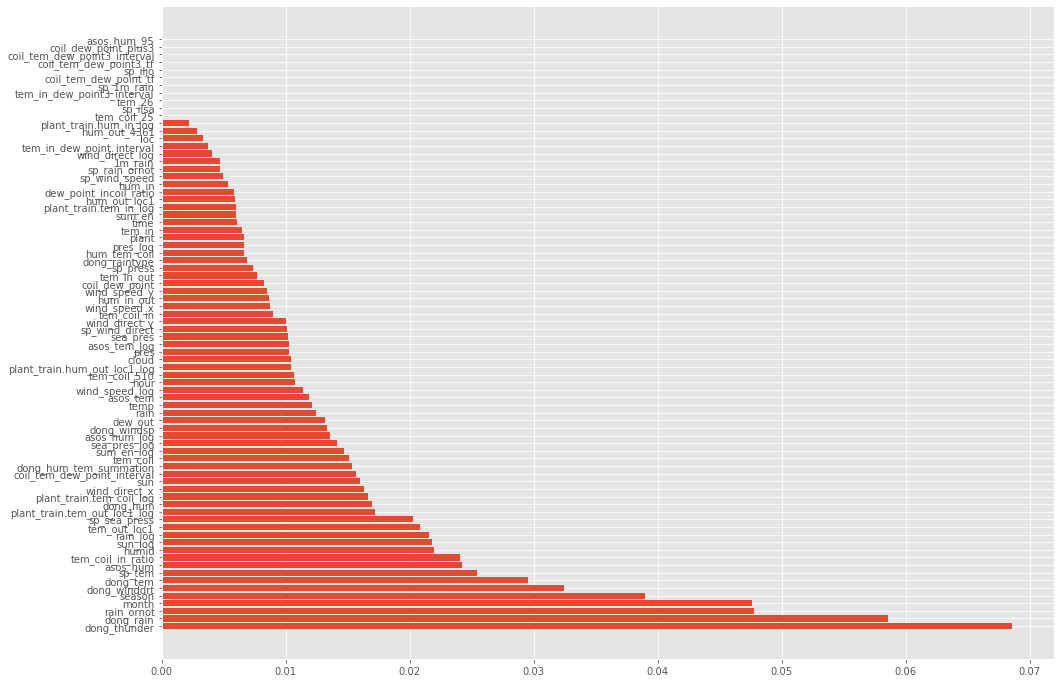

In [87]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.82495	validation_1-auc:0.82861
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99828
[200]	validation_0-auc:1.00000	validation_1-auc:0.99840
[300]	validation_0-auc:1.00000	validation_1-auc:0.99842
[400]	validation_0-auc:1.00000	validation_1-auc:0.99839
[500]	validation_0-auc:1.00000	validation_1-auc:0.99844
[600]	validation_0-auc:1.00000	validation_1-auc:0.99843
[700]	validation_0-auc:1.00000	validation_1-auc:0.99840
[800]	validation_0-auc:1.00000	validation_1-auc:0.99842
[900]	validation_0-auc:1.00000	validation_1-auc:0.99840
[999]	validation_0-auc:1.00000	validation_1-auc:0.99838
Fold  1 AUC : 0.998483
[0]	validation_0-auc:0.82580	validation_1-auc:0.80440
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 r

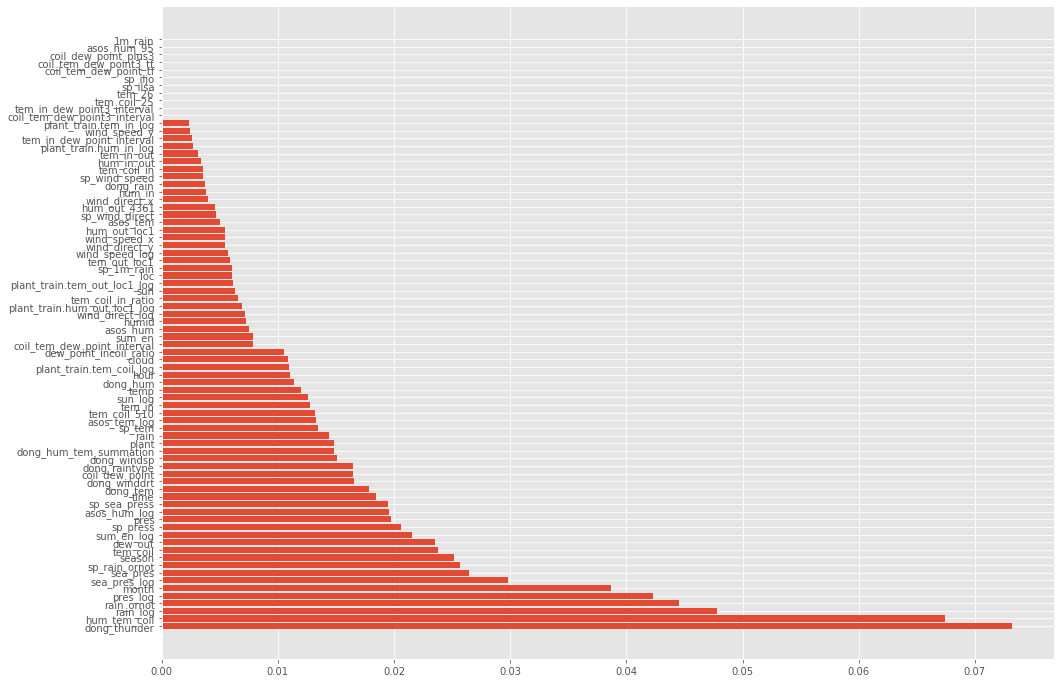

In [88]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

***위의 데이터셋에서 Hyper parameter optimazation(Grid Search)***

In [161]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[12:15:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.88088	validation_1-auc:0.85422
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[99]	validation_0-auc:1.00000	validation_1-auc:0.99906
Fold  1 AUC : 0.999098
[12:15:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find a

In [162]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[12:16:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85731	validation_1-auc:0.85122
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[99]	validation_0-auc:1.00000	validation_1-auc:0.99860
Fold  1 AUC : 0.998628
[12:17:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find a

***grid search2***

In [42]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.88311	validation_1-auc:0.85403
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99915
[200]	validation_0-auc:1.00000	validation_1-auc:0.99916
[300]	validation_0-auc:1.00000	validation_1-auc:0.99911
[400]	validation_0-auc:1.00000	validation_1-auc:0.99916
Stopping. Best iteration:
[165]	validation_0-auc:1.00000	validation_1-auc:0.99916

Fold  1 AUC : 0.999164
[0]	validation_0-auc:0.85788	validation_1-auc:0.86400
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99614
[200]	validation_0-auc:1.00000	validation_1-auc:0.99567
[300]	validation_0-auc:1.00000	validation_1-auc:0.99555
[400]	validation_0-auc:1.00000	validation_1-auc:0.99559
Stopping. Best iterati

In [43]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.87855	validation_1-auc:0.88493
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99842
[200]	validation_0-auc:1.00000	validation_1-auc:0.99862
[300]	validation_0-auc:1.00000	validation_1-auc:0.99864
[400]	validation_0-auc:1.00000	validation_1-auc:0.99862
[500]	validation_0-auc:1.00000	validation_1-auc:0.99857
Stopping. Best iteration:
[231]	validation_0-auc:1.00000	validation_1-auc:0.99867

Fold  1 AUC : 0.998670
[0]	validation_0-auc:0.82171	validation_1-auc:0.79968
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99762
[200]	validation_0-auc:1.00000	validation_1-auc:0.99770
[300]	validation_0-auc:1.00000	validation_1-auc:0.99762
Stopping. Best iterati

***위의 데이터셋중에서 이슬점 관련 파생변수까지 데이터셋 구축한 것을 이용(기본 파라미터)***

[0]	validation_0-auc:0.90541	validation_1-auc:0.89021
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99923
[200]	validation_0-auc:1.00000	validation_1-auc:0.99936
[300]	validation_0-auc:1.00000	validation_1-auc:0.99938
[400]	validation_0-auc:1.00000	validation_1-auc:0.99939
[500]	validation_0-auc:1.00000	validation_1-auc:0.99939
[600]	validation_0-auc:1.00000	validation_1-auc:0.99939
[700]	validation_0-auc:1.00000	validation_1-auc:0.99939
[800]	validation_0-auc:1.00000	validation_1-auc:0.99938
Stopping. Best iteration:
[532]	validation_0-auc:1.00000	validation_1-auc:0.99940

Fold  1 AUC : 0.999397
[0]	validation_0-auc:0.89853	validation_1-auc:0.89232
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc

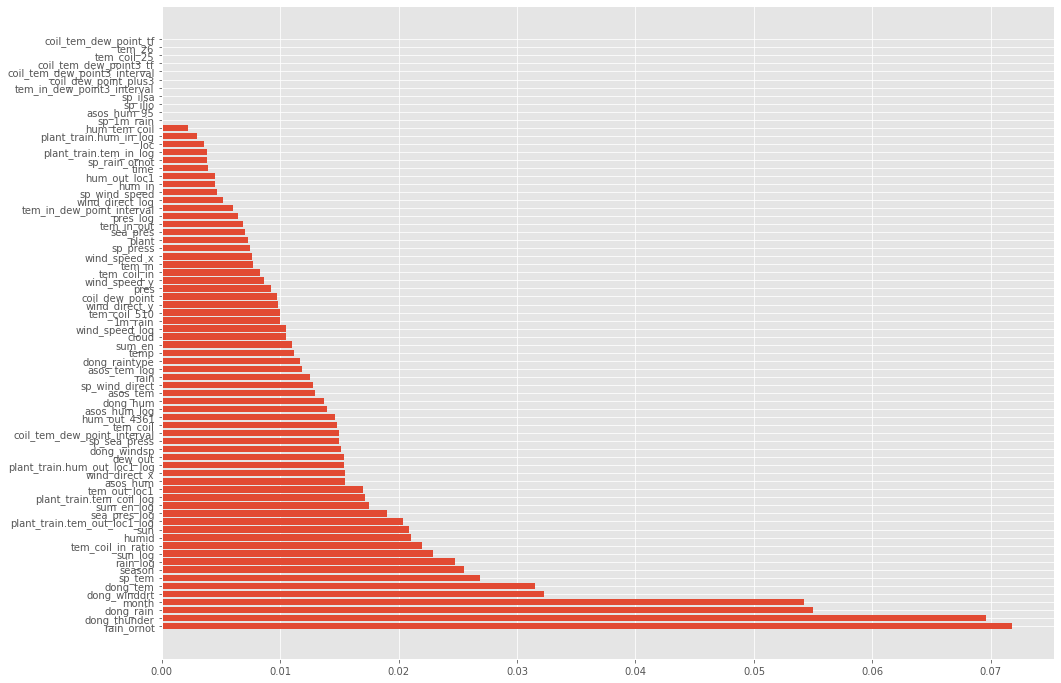

In [72]:
# 결측치를 처리한 버전
test_preds_xgb24, preds_xgb24, y_test_xgb24, feature_importance_fin_xgb24, conf_matrix_xgb24 = XGB_classifier(\
                                                                                        train_24_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

[0]	validation_0-auc:0.82411	validation_1-auc:0.82933
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99878
[200]	validation_0-auc:1.00000	validation_1-auc:0.99890
[300]	validation_0-auc:1.00000	validation_1-auc:0.99891
[400]	validation_0-auc:1.00000	validation_1-auc:0.99891
[500]	validation_0-auc:1.00000	validation_1-auc:0.99896
[600]	validation_0-auc:1.00000	validation_1-auc:0.99898
[700]	validation_0-auc:1.00000	validation_1-auc:0.99897
[800]	validation_0-auc:1.00000	validation_1-auc:0.99895
[900]	validation_0-auc:1.00000	validation_1-auc:0.99893
Stopping. Best iteration:
[600]	validation_0-auc:1.00000	validation_1-auc:0.99898

Fold  1 AUC : 0.998981
[0]	validation_0-auc:0.82576	validation_1-auc:0.80437
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

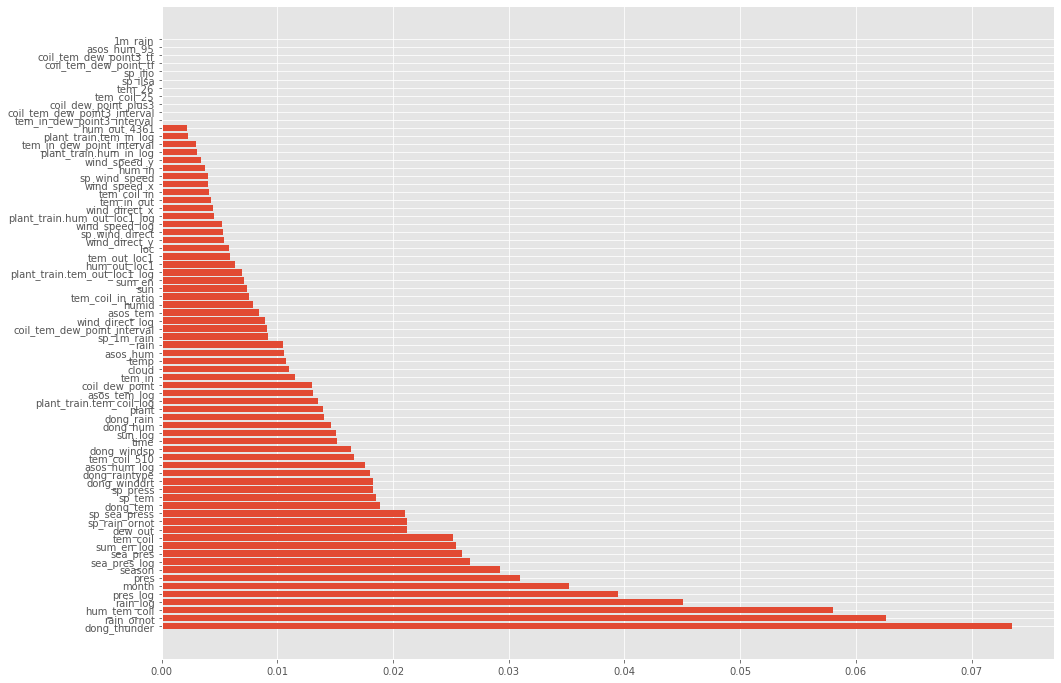

In [73]:
# 결측치를 처리한 버전
test_preds_xgb48, preds_xgb48, y_test_xgb48, feature_importance_fin_xgb48, conf_matrix_xgb48 = XGB_classifier(\
                                                                                        train_48_recent,
                                                                                        dj_ts_aws_recent,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        0.5,
                                                                                        real_train = False)

#### ***실제 모델 예측***

In [15]:
test_preds_xgb24, preds_xgb24, feature_importance_fin_xgb24 = XGB_classifier(\
                                                            df24,
                                                            test_df,
                                                            'after24_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.87758	validation_1-auc:0.87114
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.99999	validation_1-auc:0.99784
[200]	validation_0-auc:1.00000	validation_1-auc:0.99797
[300]	validation_0-auc:1.00000	validation_1-auc:0.99794
[400]	validation_0-auc:1.00000	validation_1-auc:0.99806
[500]	validation_0-auc:1.00000	validation_1-auc:0.99813
[600]	validation_0-auc:1.00000	validation_1-auc:0.99822
[700]	validation_0-auc:1.00000	validation_1-auc:0.99817
[800]	validation_0-auc:1.00000	validation_1-auc:0.99811
Stopping. Best iteration:
[597]	validation_0-auc:1.00000	validation_1-auc:0.99823

Fold  1 AUC : 0.998227
[0]	validation_0-auc:0.88360	validation_1-auc:0.89479
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc

In [16]:
test_preds_xgb48, preds_xgb48, feature_importance_fin_xgb48 = XGB_classifier(\
                                                            df48,
                                                            test_df,
                                                            'after48_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.86630	validation_1-auc:0.86432
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.99999	validation_1-auc:0.99627
[200]	validation_0-auc:1.00000	validation_1-auc:0.99631
[300]	validation_0-auc:1.00000	validation_1-auc:0.99615
[400]	validation_0-auc:1.00000	validation_1-auc:0.99598
Stopping. Best iteration:
[189]	validation_0-auc:1.00000	validation_1-auc:0.99660

Fold  1 AUC : 0.996600
[0]	validation_0-auc:0.87013	validation_1-auc:0.85952
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99595
[200]	validation_0-auc:1.00000	validation_1-auc:0.99544
[300]	validation_0-auc:1.00000	validation_1-auc:0.99567
Stopping. Best iteration:
[86]	validation_0-auc:0.99999	validation_1-auc:0.996

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o***

In [289]:
test_preds_xgb24, preds_xgb24, feature_importance_fin_xgb24 = XGB_classifier(\
                                                            train_24,
                                                            dj_ts_aws,
                                                            'after24_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.90661	validation_1-auc:0.89048
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99889
[200]	validation_0-auc:1.00000	validation_1-auc:0.99902
[300]	validation_0-auc:1.00000	validation_1-auc:0.99910
[400]	validation_0-auc:1.00000	validation_1-auc:0.99909
[500]	validation_0-auc:1.00000	validation_1-auc:0.99909
Stopping. Best iteration:
[265]	validation_0-auc:1.00000	validation_1-auc:0.99913

Fold  1 AUC : 0.999131
[0]	validation_0-auc:0.90007	validation_1-auc:0.88165
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99809
[200]	validation_0-auc:1.00000	validation_1-auc:0.99805
[300]	validation_0-auc:1.00000	validation_1-auc:0.99757
Stopping. Best iterati

In [290]:
test_preds_xgb48, preds_xgb48, feature_importance_fin_xgb48 = XGB_classifier(\
                                                            train_48,
                                                            dj_ts_aws,
                                                            'after48_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.87316	validation_1-auc:0.87760
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99948
[200]	validation_0-auc:1.00000	validation_1-auc:0.99964
[300]	validation_0-auc:1.00000	validation_1-auc:0.99967
[400]	validation_0-auc:1.00000	validation_1-auc:0.99968
[500]	validation_0-auc:1.00000	validation_1-auc:0.99967
[600]	validation_0-auc:1.00000	validation_1-auc:0.99966
Stopping. Best iteration:
[351]	validation_0-auc:1.00000	validation_1-auc:0.99969

Fold  1 AUC : 0.999688
[0]	validation_0-auc:0.88677	validation_1-auc:0.87451
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99607
[200]	validation_0-auc:1.00000	validation_1-auc:0.99616
[300]	validation_0-auc

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o + 이슬점***

In [453]:
test_preds_xgb24, preds_xgb24, feature_importance_fin_xgb24 = XGB_classifier(\
                                                            train_24_recent,
                                                            dj_ts_aws_recent,
                                                            'after24_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.90809	validation_1-auc:0.89027
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99858
[200]	validation_0-auc:1.00000	validation_1-auc:0.99858
[300]	validation_0-auc:1.00000	validation_1-auc:0.99864
[400]	validation_0-auc:1.00000	validation_1-auc:0.99859
Stopping. Best iteration:
[126]	validation_0-auc:1.00000	validation_1-auc:0.99876

Fold  1 AUC : 0.998760
[0]	validation_0-auc:0.90262	validation_1-auc:0.88656
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99849
[200]	validation_0-auc:1.00000	validation_1-auc:0.99819
[300]	validation_0-auc:1.00000	validation_1-auc:0.99789
Stopping. Best iteration:
[88]	validation_0-auc:1.00000	validation_1-auc:0.998

In [454]:
test_preds_xgb48, preds_xgb48, feature_importance_fin_xgb48 = XGB_classifier(\
                                                            train_48_recent,
                                                            dj_ts_aws_recent,
                                                            'after48_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.88152	validation_1-auc:0.88672
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99942
[200]	validation_0-auc:1.00000	validation_1-auc:0.99955
[300]	validation_0-auc:1.00000	validation_1-auc:0.99946
[400]	validation_0-auc:1.00000	validation_1-auc:0.99947
Stopping. Best iteration:
[188]	validation_0-auc:1.00000	validation_1-auc:0.99957

Fold  1 AUC : 0.999566
[0]	validation_0-auc:0.90494	validation_1-auc:0.89430
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99663
[200]	validation_0-auc:1.00000	validation_1-auc:0.99636
[300]	validation_0-auc:1.00000	validation_1-auc:0.99600
Stopping. Best iteration:
[58]	validation_0-auc:0.99997	validation_1-auc:0.996

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o + 이슬점 + 시간관련 데이터+습도기술통계량***

[0]	validation_0-auc:0.90809	validation_1-auc:0.89027
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99887
[200]	validation_0-auc:1.00000	validation_1-auc:0.99879
[300]	validation_0-auc:1.00000	validation_1-auc:0.99876
[400]	validation_0-auc:1.00000	validation_1-auc:0.99879
Stopping. Best iteration:
[106]	validation_0-auc:1.00000	validation_1-auc:0.99892

Fold  1 AUC : 0.998923
[0]	validation_0-auc:0.92754	validation_1-auc:0.91469
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99826
[200]	validation_0-auc:1.00000	validation_1-auc:0.99794
[300]	validation_0-auc:1.00000	validation_1-auc:0.99773
Stopping. Best iteration:
[69]	validation_0-auc:0.99998	validation_1-auc:0.998

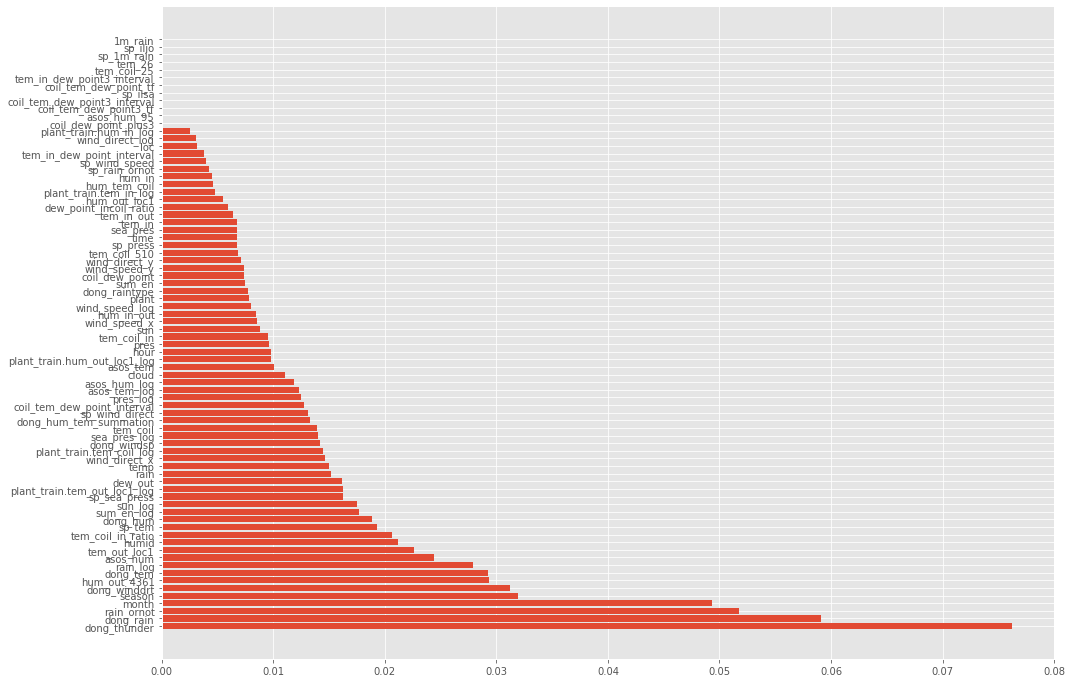

In [95]:
test_preds_xgb24, preds_xgb24, feature_importance_fin_xgb24 = XGB_classifier(\
                                                            train_24_recent,
                                                            dj_ts_aws_recent,
                                                            'after24_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.88954	validation_1-auc:0.89742
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99960
[200]	validation_0-auc:1.00000	validation_1-auc:0.99965
[300]	validation_0-auc:1.00000	validation_1-auc:0.99964
[400]	validation_0-auc:1.00000	validation_1-auc:0.99964
[500]	validation_0-auc:1.00000	validation_1-auc:0.99965
[600]	validation_0-auc:1.00000	validation_1-auc:0.99965
[700]	validation_0-auc:1.00000	validation_1-auc:0.99964
[800]	validation_0-auc:1.00000	validation_1-auc:0.99962
[900]	validation_0-auc:1.00000	validation_1-auc:0.99963
Stopping. Best iteration:
[613]	validation_0-auc:1.00000	validation_1-auc:0.99966

Fold  1 AUC : 0.999656
[0]	validation_0-auc:0.88692	validation_1-auc:0.87559
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

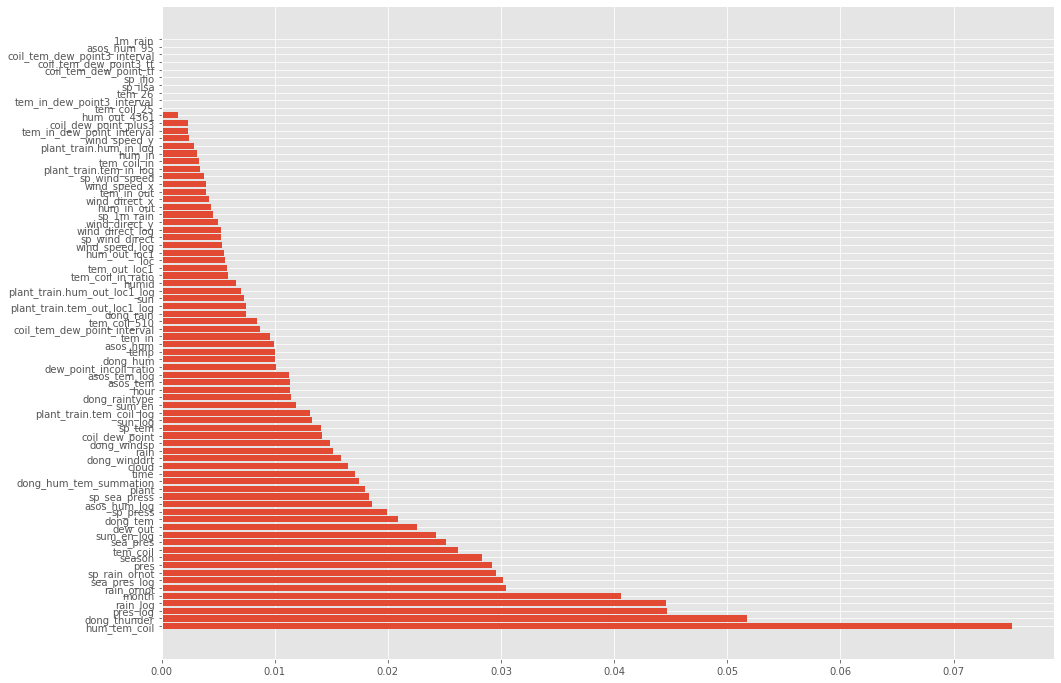

In [96]:
test_preds_xgb48, preds_xgb48, feature_importance_fin_xgb48 = XGB_classifier(\
                                                            train_48_recent,
                                                            dj_ts_aws_recent,
                                                            'after48_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

***grid search2 model***

In [192]:
test_preds_xgb24, preds_xgb24, feature_importance_fin_xgb24 = XGB_classifier(\
                                                            train_24_recent,
                                                            dj_ts_aws_recent,
                                                            'after24_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.90809	validation_1-auc:0.89027
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99858
[200]	validation_0-auc:1.00000	validation_1-auc:0.99858
[300]	validation_0-auc:1.00000	validation_1-auc:0.99864
[400]	validation_0-auc:1.00000	validation_1-auc:0.99859
Stopping. Best iteration:
[126]	validation_0-auc:1.00000	validation_1-auc:0.99876

Fold  1 AUC : 0.998760
[0]	validation_0-auc:0.90262	validation_1-auc:0.88656
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99849
[200]	validation_0-auc:1.00000	validation_1-auc:0.99819
[300]	validation_0-auc:1.00000	validation_1-auc:0.99789
Stopping. Best iteration:
[88]	validation_0-auc:1.00000	validation_1-auc:0.998

In [193]:
test_preds_xgb48, preds_xgb48, feature_importance_fin_xgb48 = XGB_classifier(\
                                                            train_48_recent,
                                                            dj_ts_aws_recent,
                                                            'after48_loc_predict',
                                                            5,
                                                            0.5,
                                                            real_train = True)

[0]	validation_0-auc:0.88152	validation_1-auc:0.88672
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99942
[200]	validation_0-auc:1.00000	validation_1-auc:0.99955
[300]	validation_0-auc:1.00000	validation_1-auc:0.99946
[400]	validation_0-auc:1.00000	validation_1-auc:0.99947
Stopping. Best iteration:
[188]	validation_0-auc:1.00000	validation_1-auc:0.99957

Fold  1 AUC : 0.999566
[0]	validation_0-auc:0.90494	validation_1-auc:0.89430
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:1.00000	validation_1-auc:0.99663
[200]	validation_0-auc:1.00000	validation_1-auc:0.99636
[300]	validation_0-auc:1.00000	validation_1-auc:0.99600
Stopping. Best iteration:
[58]	validation_0-auc:0.99997	validation_1-auc:0.996

### ***XGB Grid Search***

In [178]:
# A parameter grid for XGBoost
xgb_params = {
        ',': [0.2,0.4,0.5],
        'gamma': [0.4,0.45,0.5],
        'subsample': [0.8,0.9,0.93],
        'colsample_bytree': [0.6,0.7, 0.8],
        'max_depth': [ 4.5, 5, 5.5],
        'learning_rate' : [0.6,0.65,0.7]
        }

#24시간 뒤의 결로현상을 예측하는 교차 모델
param_comb = 5
n = 5

X = train_24_recent.drop(columns = 'after24_loc_predict')
Y = train_24_recent['after24_loc_predict']

folds= KFold(n_splits=n, shuffle = True, random_state = 1001)
xgb_clf = xgb.XGBClassifier(n_estimaters = 1000)

random_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=xgb_params, n_iter=param_comb, scoring='roc_auc', n_jobs=1, cv=folds.split(X,Y), verbose=10, random_state=1001 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search_xgb.fit(X, Y)
print('걸린 시간 : ', time.time() - start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6, score=nan, total=   0.8s
[CV] subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6, score=nan, total=   0.8s
[CV] subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6, score=nan, total=   0.7s
[CV] subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6, score=nan, total=   0.7s
[CV] subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.2, max_depth=4.5, learning_rate=0.65, gamma=0.5, colsample_bytree=0.6, score=nan, total=   0.8s
[CV] subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s


[12:56:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7, score=0.999, total=  13.9s
[CV] subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   17.9s remaining:    0.0s


[12:56:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7, score=0.997, total=  14.7s
[CV] subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.6s remaining:    0.0s


[12:57:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7, score=0.999, total=  14.8s
[CV] subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.4s remaining:    0.0s


[12:57:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7, score=0.999, total=  14.5s
[CV] subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[12:57:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_weight=0.5, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.7, score=0.999, total=  14.6s
[CV] subsample=0.9, min_child_weight=0.4, max_depth=5, learning_rate=0.65, gamma=0.4, colsample_bytree=0.8 
[12:57:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, min_child_w

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.7min finished


[13:00:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


걸린 시간 :  237.00082993507385


In [171]:
print('------------------------------------')
print(xgb_params)
print('------------------------------------')
print(random_search_xgb.best_estimator_)
print('------------------------------------')
print(random_search_xgb.best_params_)
print('------------------------------------')
print(random_search_xgb.best_score_)
print('------------------------------------')

------------------------------------
{'min_child_weight': [0.2, 0.5, 1], 'gamma': [0.4, 0.5, 1], 'subsample': [0.6, 0.8, 1.2], 'colsample_bytree': [0.3, 0.6, 0.8, 1], 'max_depth': [4, 5, 6], 'learning_rate': [0.4, 0.6, 0.8]}
------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7, max_delta_step=0, max_depth=5,
              min_child_weight=0.4, missing=nan, monotone_constraints='()',
              n_estimaters=1000, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
------------------------------------
{'subsample': 0.9, 'min_child_weight': 0.4, 'max_depth': 

In [175]:
print('------------------------------------')
print(xgb_params)
print('------------------------------------')
print(random_search_xgb.best_estimator_)
print('------------------------------------')
print(random_search_xgb.best_params_)
print('------------------------------------')
print(random_search_xgb.best_score_)
print('------------------------------------')

------------------------------------
{'min_child_weight': [0.2, 0.4, 0.5], 'gamma': [0.4, 0.5, 0.7], 'subsample': [0.8, 0.9, 1.2], 'colsample_bytree': [0.6, 0.7, 0.8], 'max_depth': [4.5, 5, 5.5], 'learning_rate': [0.6, 0.7, 0.8]}
------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7, max_delta_step=0, max_depth=5,
              min_child_weight=0.4, missing=nan, monotone_constraints='()',
              n_estimaters=1000, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
------------------------------------
{'subsample': 0.9, 'min_child_weight': 0.4, 'max_dep

In [179]:
print('------------------------------------')
print(xgb_params)
print('------------------------------------')
print(random_search_xgb.best_estimator_)
print('------------------------------------')
print(random_search_xgb.best_params_)
print('------------------------------------')
print(random_search_xgb.best_score_)
print('------------------------------------')

------------------------------------
{'min_child_weight': [0.2, 0.4, 0.5], 'gamma': [0.4, 0.45, 0.5], 'subsample': [0.8, 0.9, 0.93], 'colsample_bytree': [0.6, 0.7, 0.8], 'max_depth': [4.5, 5, 5.5], 'learning_rate': [0.6, 0.65, 0.7]}
------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.65, max_delta_step=0, max_depth=5,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimaters=1000, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)
------------------------------------
{'subsample': 0.9, 'min_child_weight': 0.5, 'max

#### ***Cut off에 따른 CSI검증***

In [ ]:
csi_ls = []
cut_off_ls = []
for i in [0.4,0.45,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64]:
    test_preds_xgb, preds_xgb, y_test_xgb, feature_importance_fin_xgb, conf_matrix_xgb = XGB_classifier(\
                                                                                        df24,
                                                                                        test_df,
                                                                                        'after24_loc_predict',
                                                                                        5,
                                                                                        i,
                                                                                        real_train = False)    
    csi = conf_matrix_xgb[0,0] / (conf_matrix_xgb[0,0] + conf_matrix_xgb[0,1] + conf_matrix_xgb[1,0])
    
    csi_ls.append(csi)
    cut_off_ls.append(i)
    
    print('Cut off : ',i)    
    print('모델 종합 성능 : ', csi)

    
csi_df = pd.DataFrame()
csi_df['cut_off'] = cut_off_ls
csi_df['CSI'] = csi_ls
# 0.4부터 csi성능이 수렴 ->

In [ ]:
csi_df

In [ ]:
csi_ls = []
cut_off_ls = []
for i in [0.4,0.45,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64]:
    test_preds_xgb, preds_xgb, y_test_xgb, feature_importance_fin_xgb, conf_matrix_xgb = XGB_classifier(\
                                                                                        df48,
                                                                                        test_df,
                                                                                        'after48_loc_predict',
                                                                                        5,
                                                                                        i,
                                                                                        real_train = False)    
    csi = conf_matrix_xgb[0,0] / (conf_matrix_xgb[0,0] + conf_matrix_xgb[0,1] + conf_matrix_xgb[1,0])
    
    csi_ls.append(csi)
    cut_off_ls.append(i)
    
    print('Cut off : ',i)    
    print('모델 종합 성능 : ', csi)

    
csi_df = pd.DataFrame()
csi_df['cut_off'] = cut_off_ls
csi_df['CSI'] = csi_ls

In [ ]:
csi_df

## ***LGBM***

In [89]:
def LGBM_classifier(df, test_df, target_variable, num_folds,cut_off , real_train = False):
    
    if real_train == False:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target_variable),df[target_variable],test_size = 0.25, random_state = 0)

        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

        oof_preds = np.zeros(X_train.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        feature_importance_df = pd.DataFrame()

        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # 파라미터 삽입
            '''params = {}boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, gamma=0.4, importance_type='split',
               learning_rate=0.6, max_depth=5, min_child_samples=20,
               min_child_weight=0.5, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0'''
            clf = lgb.LGBMClassifier(class_weight = 'balanced', n_estimators = 1000)

            # 모델 평가척도로 어떤것을 사용할 것인지
            clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='auc', verbose= 100, early_stopping_rounds=300)

            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:,1]
            test_preds += clf.predict_proba(X_test, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)

        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)

        print('Test AUC score : ', roc_auc_score(y_test, test_preds))
        conf_matrix = confusion_matrix(y_test, preds,labels = [1,0])
        
        plt.figure(figsize = (16,12))
        plt.barh(feature_importance_fin.index,feature_importance_fin['importance'])


        return test_preds, preds, y_test, feature_importance_fin, conf_matrix
    
    elif real_train == True:
        
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
        
        test_preds = np.zeros(test_df.shape[0])
        feature_importance_df = pd.DataFrame()
        
        X_train = df.drop(columns = target_variable)
        y_train = df[target_variable]
        
        oof_preds = np.zeros(X_train.shape[0])
        
        test_df = test_df[X_train.columns.tolist()] #컬럼 순서를 맞춰주기 위한 장치
        
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            # 파라미터 삽입
            '''params = {}'''
            clf = lgb.LGBMClassifier(class_weight = 'balanced', n_estimators = 1000)

            # 모델 평가척도로 어떤것을 사용할 것인지
            clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='auc', verbose= 100, early_stopping_rounds=300)

            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:,1]
            test_preds += clf.predict_proba(test_df, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)

        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)
                
        plt.figure(figsize = (16,12))
        plt.barh(feature_importance_fin.index,feature_importance_fin['importance'])


        return test_preds, preds, feature_importance_fin

#### ***LGBM Cut off에 따른 CSI검증***

In [272]:
csi_ls = []
cut_off_ls = []
for i in [0.2,0.3,0.35,0.4,0.45,0.5]:
    test_preds, preds, y_test, feature_importance_fin, conf_matrix = LGBM_classifier(\
                                                                                    df24,
                                                                                    test_df,
                                                                                    'after24_loc_predict',
                                                                                    5,
                                                                                    i,
                                                                                    real_train = False)
    
    csi = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1] + conf_matrix[1,0])
    
    csi_ls.append(csi)
    cut_off_ls.append(i)
    
    print('Cut off : ',i)    
    print('모델 종합 성능 : ', csi)
    
csi_df = pd.DataFrame()
csi_df['cut_off'] = cut_off_ls
csi_df['CSI'] = csi_ls

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999848	training's binary_logloss: 0.0211796	valid_1's auc: 0.998776	valid_1's binary_logloss: 0.0251447
[200]	training's auc: 0.999985	training's binary_logloss: 0.00549766	valid_1's auc: 0.998405	valid_1's binary_logloss: 0.00896182
[300]	training's auc: 1	training's binary_logloss: 0.0018869	valid_1's auc: 0.998958	valid_1's binary_logloss: 0.00577751
[400]	training's auc: 1	training's binary_logloss: 0.000684037	valid_1's auc: 0.999042	valid_1's binary_logloss: 0.00484898
Early stopping, best iteration is:
[173]	training's auc: 0.999969	training's binary_logloss: 0.00748275	valid_1's auc: 0.999169	valid_1's binary_logloss: 0.0105204
Fold  1 AUC : 0.999169
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999841	training's binary_logloss: 0.0194087	valid_1's auc: 0.99561	valid_1's binary_logloss: 0.0255402
[200]	training's auc: 0.999996	training's binary_logloss: 

[300]	training's auc: 1	training's binary_logloss: 0.00153999	valid_1's auc: 0.997086	valid_1's binary_logloss: 0.0080346
[400]	training's auc: 1	training's binary_logloss: 0.000542545	valid_1's auc: 0.997229	valid_1's binary_logloss: 0.00756731
[500]	training's auc: 1	training's binary_logloss: 0.000191258	valid_1's auc: 0.99721	valid_1's binary_logloss: 0.0076978
[600]	training's auc: 1	training's binary_logloss: 6.95119e-05	valid_1's auc: 0.997455	valid_1's binary_logloss: 0.00803474
[700]	training's auc: 1	training's binary_logloss: 2.72908e-05	valid_1's auc: 0.997468	valid_1's binary_logloss: 0.00846099
Early stopping, best iteration is:
[421]	training's auc: 1	training's binary_logloss: 0.000429936	valid_1's auc: 0.997213	valid_1's binary_logloss: 0.00753016
Fold  5 AUC : 0.997213
Full AUC score 0.995507
Test AUC score :  0.9989842687207284
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999848	training's binary_logloss: 0.0211796	valid_1's a

[400]	training's auc: 1	training's binary_logloss: 0.000586527	valid_1's auc: 0.999269	valid_1's binary_logloss: 0.00577858
[500]	training's auc: 1	training's binary_logloss: 0.000224419	valid_1's auc: 0.999273	valid_1's binary_logloss: 0.00596391
[600]	training's auc: 1	training's binary_logloss: 8.53599e-05	valid_1's auc: 0.999259	valid_1's binary_logloss: 0.00645412
Early stopping, best iteration is:
[388]	training's auc: 1	training's binary_logloss: 0.000659464	valid_1's auc: 0.999279	valid_1's binary_logloss: 0.0057416
Fold  4 AUC : 0.999279
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999859	training's binary_logloss: 0.0190352	valid_1's auc: 0.996299	valid_1's binary_logloss: 0.0259388
[200]	training's auc: 0.999987	training's binary_logloss: 0.00490583	valid_1's auc: 0.996966	valid_1's binary_logloss: 0.0107576
[300]	training's auc: 1	training's binary_logloss: 0.00153999	valid_1's auc: 0.997086	valid_1's binary_logloss: 0.0080346
[400]	

[200]	training's auc: 0.999985	training's binary_logloss: 0.00530381	valid_1's auc: 0.991113	valid_1's binary_logloss: 0.0104592
[300]	training's auc: 1	training's binary_logloss: 0.00165727	valid_1's auc: 0.991317	valid_1's binary_logloss: 0.00730537
Early stopping, best iteration is:
[94]	training's auc: 0.99981	training's binary_logloss: 0.0228996	valid_1's auc: 0.996514	valid_1's binary_logloss: 0.0294753
Fold  3 AUC : 0.996514
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999855	training's binary_logloss: 0.0203962	valid_1's auc: 0.998891	valid_1's binary_logloss: 0.0240435
[200]	training's auc: 0.999991	training's binary_logloss: 0.00510978	valid_1's auc: 0.99918	valid_1's binary_logloss: 0.00871316
[300]	training's auc: 1	training's binary_logloss: 0.00168417	valid_1's auc: 0.999205	valid_1's binary_logloss: 0.00623673
[400]	training's auc: 1	training's binary_logloss: 0.000586527	valid_1's auc: 0.999269	valid_1's binary_logloss: 0.0057785

In [ ]:
csi_ls = []
cut_off_ls = []
for i in [0.2,0.3,0.35,0.4,0.45,0.5]:
    test_preds, preds, y_test, feature_importance_fin, conf_matrix = LGBM_classifier(\
                                                                                    df24,
                                                                                    test_df,
                                                                                    'after24_loc_predict',
                                                                                    5,
                                                                                    i,
                                                                                    real_train = False)
    
    csi = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1] + conf_matrix[1,0])
    
    csi_ls.append(csi)
    cut_off_ls.append(i)
    
csi_df = pd.DataFrame()
csi_df['cut_off'] = cut_off_ls
csi_df['CSI'] = csi_ls

In [273]:
csi_df

,cut_off,CSI
0,0.20,0.457510
1,0.30,0.616000
2,0.35,0.663280
3,0.40,0.707165
4,0.45,0.728155
5,0.50,0.745819


In [274]:
csi_ls = []
cut_off_ls = []
for i in [0.4,0.45,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64]:
    test_preds, preds, y_test, feature_importance_fin, conf_matrix = LGBM_classifier(\
                                                                                    df24,
                                                                                    test_df,
                                                                                    'after24_loc_predict',
                                                                                    5,
                                                                                    i,
                                                                                    real_train = False)
    
    csi = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1] + conf_matrix[1,0])
    
    csi_ls.append(csi)
    cut_off_ls.append(i)
    
    print('Cut off : ',i)    
    print('모델 종합 성능 : ', csi)
    
csi_df = pd.DataFrame()
csi_df['cut_off'] = cut_off_ls
csi_df['CSI'] = csi_ls

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999848	training's binary_logloss: 0.0211796	valid_1's auc: 0.998776	valid_1's binary_logloss: 0.0251447
[200]	training's auc: 0.999985	training's binary_logloss: 0.00549766	valid_1's auc: 0.998405	valid_1's binary_logloss: 0.00896182
[300]	training's auc: 1	training's binary_logloss: 0.0018869	valid_1's auc: 0.998958	valid_1's binary_logloss: 0.00577751
[400]	training's auc: 1	training's binary_logloss: 0.000684037	valid_1's auc: 0.999042	valid_1's binary_logloss: 0.00484898
Early stopping, best iteration is:
[173]	training's auc: 0.999969	training's binary_logloss: 0.00748275	valid_1's auc: 0.999169	valid_1's binary_logloss: 0.0105204
Fold  1 AUC : 0.999169
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999841	training's binary_logloss: 0.0194087	valid_1's auc: 0.99561	valid_1's binary_logloss: 0.0255402
[200]	training's auc: 0.999996	training's binary_logloss: 

[300]	training's auc: 1	training's binary_logloss: 0.00153999	valid_1's auc: 0.997086	valid_1's binary_logloss: 0.0080346
[400]	training's auc: 1	training's binary_logloss: 0.000542545	valid_1's auc: 0.997229	valid_1's binary_logloss: 0.00756731
[500]	training's auc: 1	training's binary_logloss: 0.000191258	valid_1's auc: 0.99721	valid_1's binary_logloss: 0.0076978
[600]	training's auc: 1	training's binary_logloss: 6.95119e-05	valid_1's auc: 0.997455	valid_1's binary_logloss: 0.00803474
[700]	training's auc: 1	training's binary_logloss: 2.72908e-05	valid_1's auc: 0.997468	valid_1's binary_logloss: 0.00846099
Early stopping, best iteration is:
[421]	training's auc: 1	training's binary_logloss: 0.000429936	valid_1's auc: 0.997213	valid_1's binary_logloss: 0.00753016
Fold  5 AUC : 0.997213
Full AUC score 0.995507
Test AUC score :  0.9989842687207284
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999848	training's binary_logloss: 0.0211796	valid_1's a

[400]	training's auc: 1	training's binary_logloss: 0.000586527	valid_1's auc: 0.999269	valid_1's binary_logloss: 0.00577858
[500]	training's auc: 1	training's binary_logloss: 0.000224419	valid_1's auc: 0.999273	valid_1's binary_logloss: 0.00596391
[600]	training's auc: 1	training's binary_logloss: 8.53599e-05	valid_1's auc: 0.999259	valid_1's binary_logloss: 0.00645412
Early stopping, best iteration is:
[388]	training's auc: 1	training's binary_logloss: 0.000659464	valid_1's auc: 0.999279	valid_1's binary_logloss: 0.0057416
Fold  4 AUC : 0.999279
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999859	training's binary_logloss: 0.0190352	valid_1's auc: 0.996299	valid_1's binary_logloss: 0.0259388
[200]	training's auc: 0.999987	training's binary_logloss: 0.00490583	valid_1's auc: 0.996966	valid_1's binary_logloss: 0.0107576
[300]	training's auc: 1	training's binary_logloss: 0.00153999	valid_1's auc: 0.997086	valid_1's binary_logloss: 0.0080346
[400]	

[200]	training's auc: 0.999985	training's binary_logloss: 0.00530381	valid_1's auc: 0.991113	valid_1's binary_logloss: 0.0104592
[300]	training's auc: 1	training's binary_logloss: 0.00165727	valid_1's auc: 0.991317	valid_1's binary_logloss: 0.00730537
Early stopping, best iteration is:
[94]	training's auc: 0.99981	training's binary_logloss: 0.0228996	valid_1's auc: 0.996514	valid_1's binary_logloss: 0.0294753
Fold  3 AUC : 0.996514
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999855	training's binary_logloss: 0.0203962	valid_1's auc: 0.998891	valid_1's binary_logloss: 0.0240435
[200]	training's auc: 0.999991	training's binary_logloss: 0.00510978	valid_1's auc: 0.99918	valid_1's binary_logloss: 0.00871316
[300]	training's auc: 1	training's binary_logloss: 0.00168417	valid_1's auc: 0.999205	valid_1's binary_logloss: 0.00623673
[400]	training's auc: 1	training's binary_logloss: 0.000586527	valid_1's auc: 0.999269	valid_1's binary_logloss: 0.0057785

In [275]:
csi_df

,cut_off,CSI
0,0.52,0.749580
1,0.54,0.756849
2,0.56,0.762976
3,0.58,0.768827
4,0.60,0.775221
5,0.62,0.784173
6,0.64,0.783784


In [277]:
csi_ls = []
cut_off_ls = []
for i in [0.4,0.45,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64]:
    test_preds, preds, y_test, feature_importance_fin, conf_matrix = LGBM_classifier(\
                                                                                    df48,
                                                                                    test_df,
                                                                                    'after48_loc_predict',
                                                                                    5,
                                                                                    i,
                                                                                    real_train = False)
    
    csi = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1] + conf_matrix[1,0])
    
    csi_ls.append(csi)
    cut_off_ls.append(i)
    
    print('Cut off : ',i)    
    print('모델 종합 성능 : ', csi)
    
csi_df = pd.DataFrame()
csi_df['cut_off'] = cut_off_ls
csi_df['CSI'] = csi_ls

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999835	training's binary_logloss: 0.0286117	valid_1's auc: 0.995489	valid_1's binary_logloss: 0.0353051
[200]	training's auc: 0.999979	training's binary_logloss: 0.00794689	valid_1's auc: 0.994865	valid_1's binary_logloss: 0.0125069
[300]	training's auc: 1	training's binary_logloss: 0.00268532	valid_1's auc: 0.994652	valid_1's binary_logloss: 0.00747565
[400]	training's auc: 1	training's binary_logloss: 0.00101626	valid_1's auc: 0.994715	valid_1's binary_logloss: 0.00615847
Early stopping, best iteration is:
[117]	training's auc: 0.999889	training's binary_logloss: 0.0222492	valid_1's auc: 0.995697	valid_1's binary_logloss: 0.0284142
Fold  1 AUC : 0.995697
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999812	training's binary_logloss: 0.0300344	valid_1's auc: 0.997526	valid_1's binary_logloss: 0.0357009
[200]	training's auc: 0.999978	training's binary_logloss: 0

Fold  4 AUC : 0.992254
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999818	training's binary_logloss: 0.0284169	valid_1's auc: 0.99434	valid_1's binary_logloss: 0.0341142
[200]	training's auc: 0.999986	training's binary_logloss: 0.00818159	valid_1's auc: 0.995336	valid_1's binary_logloss: 0.012306
[300]	training's auc: 1	training's binary_logloss: 0.00280408	valid_1's auc: 0.995729	valid_1's binary_logloss: 0.00713916
[400]	training's auc: 1	training's binary_logloss: 0.00105108	valid_1's auc: 0.995955	valid_1's binary_logloss: 0.00560753
[500]	training's auc: 1	training's binary_logloss: 0.00042418	valid_1's auc: 0.995899	valid_1's binary_logloss: 0.0052738
[600]	training's auc: 1	training's binary_logloss: 0.00016719	valid_1's auc: 0.995646	valid_1's binary_logloss: 0.00537982
[700]	training's auc: 1	training's binary_logloss: 6.58878e-05	valid_1's auc: 0.995741	valid_1's binary_logloss: 0.00568028
Early stopping, best iteration is:
[415]	trai

[600]	training's auc: 1	training's binary_logloss: 0.000147441	valid_1's auc: 0.996377	valid_1's binary_logloss: 0.00662962
Early stopping, best iteration is:
[370]	training's auc: 1	training's binary_logloss: 0.00122811	valid_1's auc: 0.996537	valid_1's binary_logloss: 0.00634508
Fold  3 AUC : 0.996537
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999861	training's binary_logloss: 0.0281701	valid_1's auc: 0.991432	valid_1's binary_logloss: 0.0351191
[200]	training's auc: 0.999988	training's binary_logloss: 0.00772842	valid_1's auc: 0.991867	valid_1's binary_logloss: 0.0128525
[300]	training's auc: 1	training's binary_logloss: 0.0026532	valid_1's auc: 0.989483	valid_1's binary_logloss: 0.00828365
[400]	training's auc: 1	training's binary_logloss: 0.00099743	valid_1's auc: 0.990546	valid_1's binary_logloss: 0.00702278
[500]	training's auc: 1	training's binary_logloss: 0.000380056	valid_1's auc: 0.991008	valid_1's binary_logloss: 0.00684543
Early s

[400]	training's auc: 1	training's binary_logloss: 0.00119762	valid_1's auc: 0.992389	valid_1's binary_logloss: 0.00604
[500]	training's auc: 1	training's binary_logloss: 0.000468729	valid_1's auc: 0.994068	valid_1's binary_logloss: 0.00535254
Early stopping, best iteration is:
[256]	training's auc: 0.99999	training's binary_logloss: 0.00486828	valid_1's auc: 0.998243	valid_1's binary_logloss: 0.00904806
Fold  2 AUC : 0.998243
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999833	training's binary_logloss: 0.0274385	valid_1's auc: 0.994092	valid_1's binary_logloss: 0.0323826
[200]	training's auc: 0.999986	training's binary_logloss: 0.00742055	valid_1's auc: 0.995841	valid_1's binary_logloss: 0.0113672
[300]	training's auc: 1	training's binary_logloss: 0.0024825	valid_1's auc: 0.996153	valid_1's binary_logloss: 0.0071782
[400]	training's auc: 1	training's binary_logloss: 0.00090577	valid_1's auc: 0.996425	valid_1's binary_logloss: 0.00625565
[500]	

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999835	training's binary_logloss: 0.0286117	valid_1's auc: 0.995489	valid_1's binary_logloss: 0.0353051
[200]	training's auc: 0.999979	training's binary_logloss: 0.00794689	valid_1's auc: 0.994865	valid_1's binary_logloss: 0.0125069
[300]	training's auc: 1	training's binary_logloss: 0.00268532	valid_1's auc: 0.994652	valid_1's binary_logloss: 0.00747565
[400]	training's auc: 1	training's binary_logloss: 0.00101626	valid_1's auc: 0.994715	valid_1's binary_logloss: 0.00615847
Early stopping, best iteration is:
[117]	training's auc: 0.999889	training's binary_logloss: 0.0222492	valid_1's auc: 0.995697	valid_1's binary_logloss: 0.0284142
Fold  1 AUC : 0.995697
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999812	training's binary_logloss: 0.0300344	valid_1's auc: 0.997526	valid_1's binary_logloss: 0.0357009
[200]	training's auc: 0.999978	training's binary_logloss: 0

Fold  4 AUC : 0.992254
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999818	training's binary_logloss: 0.0284169	valid_1's auc: 0.99434	valid_1's binary_logloss: 0.0341142
[200]	training's auc: 0.999986	training's binary_logloss: 0.00818159	valid_1's auc: 0.995336	valid_1's binary_logloss: 0.012306
[300]	training's auc: 1	training's binary_logloss: 0.00280408	valid_1's auc: 0.995729	valid_1's binary_logloss: 0.00713916
[400]	training's auc: 1	training's binary_logloss: 0.00105108	valid_1's auc: 0.995955	valid_1's binary_logloss: 0.00560753
[500]	training's auc: 1	training's binary_logloss: 0.00042418	valid_1's auc: 0.995899	valid_1's binary_logloss: 0.0052738
[600]	training's auc: 1	training's binary_logloss: 0.00016719	valid_1's auc: 0.995646	valid_1's binary_logloss: 0.00537982
[700]	training's auc: 1	training's binary_logloss: 6.58878e-05	valid_1's auc: 0.995741	valid_1's binary_logloss: 0.00568028
Early stopping, best iteration is:
[415]	trai

In [278]:
csi_df

,cut_off,CSI
0,0.40,0.636364
1,0.45,0.669086
2,0.50,0.693353
3,0.52,0.707883
4,0.54,0.714063
5,0.56,0.721959
6,0.58,0.731511
7,0.60,0.734095
8,0.62,0.741294
9,0.64,0.748322


#### ***LGBM 검증***

***결측치를 처리하지 않은 베이스 데이터셋***

In [236]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                df24,
                                                                                test_df,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999848	training's binary_logloss: 0.0211796	valid_1's auc: 0.998776	valid_1's binary_logloss: 0.0251447
[200]	training's auc: 0.999985	training's binary_logloss: 0.00549766	valid_1's auc: 0.998405	valid_1's binary_logloss: 0.00896182
[300]	training's auc: 1	training's binary_logloss: 0.0018869	valid_1's auc: 0.998958	valid_1's binary_logloss: 0.00577751
[400]	training's auc: 1	training's binary_logloss: 0.000684037	valid_1's auc: 0.999042	valid_1's binary_logloss: 0.00484898
Early stopping, best iteration is:
[173]	training's auc: 0.999969	training's binary_logloss: 0.00748275	valid_1's auc: 0.999169	valid_1's binary_logloss: 0.0105204
Fold  1 AUC : 0.999169
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999841	training's binary_logloss: 0.0194087	valid_1's auc: 0.99561	valid_1's binary_logloss: 0.0255402
[200]	training's auc: 0.999996	training's binary_logloss: 

In [237]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                df48,
                                                                                test_df,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999835	training's binary_logloss: 0.0286117	valid_1's auc: 0.995489	valid_1's binary_logloss: 0.0353051
[200]	training's auc: 0.999979	training's binary_logloss: 0.00794689	valid_1's auc: 0.994865	valid_1's binary_logloss: 0.0125069
[300]	training's auc: 1	training's binary_logloss: 0.00268532	valid_1's auc: 0.994652	valid_1's binary_logloss: 0.00747565
[400]	training's auc: 1	training's binary_logloss: 0.00101626	valid_1's auc: 0.994715	valid_1's binary_logloss: 0.00615847
Early stopping, best iteration is:
[117]	training's auc: 0.999889	training's binary_logloss: 0.0222492	valid_1's auc: 0.995697	valid_1's binary_logloss: 0.0284142
Fold  1 AUC : 0.995697
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999812	training's binary_logloss: 0.0300344	valid_1's auc: 0.997526	valid_1's binary_logloss: 0.0357009
[200]	training's auc: 0.999978	training's binary_logloss: 0

***결측치를 처리한 베이스 데이터셋***

In [130]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24,
                                                                                dj_ts_awsts_aws_ts_aws,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999825	training's binary_logloss: 0.0218835	valid_1's auc: 0.997859	valid_1's binary_logloss: 0.0280524
[200]	training's auc: 0.999989	training's binary_logloss: 0.00557638	valid_1's auc: 0.998103	valid_1's binary_logloss: 0.0104789
[300]	training's auc: 1	training's binary_logloss: 0.0018453	valid_1's auc: 0.998004	valid_1's binary_logloss: 0.00697804
[400]	training's auc: 1	training's binary_logloss: 0.000658235	valid_1's auc: 0.997886	valid_1's binary_logloss: 0.00616941
Early stopping, best iteration is:
[164]	training's auc: 0.999959	training's binary_logloss: 0.00851732	valid_1's auc: 0.998285	valid_1's binary_logloss: 0.0132594
Fold  1 AUC : 0.998285
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999855	training's binary_logloss: 0.0202222	valid_1's auc: 0.995692	valid_1's binary_logloss: 0.0252551
[200]	training's auc: 0.999988	training's binary_logloss: 

In [131]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48,
                                                                                dj_ts_aws,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999796	training's binary_logloss: 0.0300599	valid_1's auc: 0.997539	valid_1's binary_logloss: 0.0359868
[200]	training's auc: 0.999985	training's binary_logloss: 0.00844161	valid_1's auc: 0.998326	valid_1's binary_logloss: 0.0125917
[300]	training's auc: 1	training's binary_logloss: 0.00305976	valid_1's auc: 0.998283	valid_1's binary_logloss: 0.00724576
[400]	training's auc: 1	training's binary_logloss: 0.00120179	valid_1's auc: 0.998092	valid_1's binary_logloss: 0.00547895
[500]	training's auc: 1	training's binary_logloss: 0.000489911	valid_1's auc: 0.997959	valid_1's binary_logloss: 0.00492417
Early stopping, best iteration is:
[237]	training's auc: 0.999991	training's binary_logloss: 0.00573526	valid_1's auc: 0.998503	valid_1's binary_logloss: 0.00978897
Fold  1 AUC : 0.998503
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999788	training's binary_logloss: 0.0

***결측치 처리x + 신평aws + 동네예보***

In [159]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24,
                                                                                dj_ts_aws,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.99991	training's binary_logloss: 0.01606	valid_1's auc: 0.998917	valid_1's binary_logloss: 0.0208697
[200]	training's auc: 0.999995	training's binary_logloss: 0.00379077	valid_1's auc: 0.993746	valid_1's binary_logloss: 0.00868341
[300]	training's auc: 1	training's binary_logloss: 0.00112178	valid_1's auc: 0.996842	valid_1's binary_logloss: 0.00668786
[400]	training's auc: 1	training's binary_logloss: 0.000370802	valid_1's auc: 0.997614	valid_1's binary_logloss: 0.00633146
Early stopping, best iteration is:
[129]	training's auc: 0.999951	training's binary_logloss: 0.0100853	valid_1's auc: 0.999095	valid_1's binary_logloss: 0.0143394
Fold  1 AUC : 0.999095
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999897	training's binary_logloss: 0.0153278	valid_1's auc: 0.997285	valid_1's binary_logloss: 0.020019
[200]	training's auc: 0.999996	training's binary_logloss: 0.0

In [160]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48,
                                                                                dj_ts_aws,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999854	training's binary_logloss: 0.0241958	valid_1's auc: 0.998321	valid_1's binary_logloss: 0.0294044
[200]	training's auc: 0.999993	training's binary_logloss: 0.00632774	valid_1's auc: 0.998769	valid_1's binary_logloss: 0.0104774
[300]	training's auc: 1	training's binary_logloss: 0.00210333	valid_1's auc: 0.99903	valid_1's binary_logloss: 0.00636353
[400]	training's auc: 1	training's binary_logloss: 0.000746214	valid_1's auc: 0.999053	valid_1's binary_logloss: 0.00510829
[500]	training's auc: 1	training's binary_logloss: 0.000287242	valid_1's auc: 0.998959	valid_1's binary_logloss: 0.00496649
[600]	training's auc: 1	training's binary_logloss: 0.000108768	valid_1's auc: 0.999033	valid_1's binary_logloss: 0.00502446
Early stopping, best iteration is:
[362]	training's auc: 1	training's binary_logloss: 0.00108095	valid_1's auc: 0.999123	valid_1's binary_logloss: 0.00531634
Fold  1 AUC : 0.999123
Traini

***결측치 처리 + 신평aws + 동네예보***

In [228]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24,
                                                                                dj_ts_aws,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999926	training's binary_logloss: 0.0123329	valid_1's auc: 0.999136	valid_1's binary_logloss: 0.0169686
[200]	training's auc: 0.999999	training's binary_logloss: 0.00258894	valid_1's auc: 0.99934	valid_1's binary_logloss: 0.00709047
[300]	training's auc: 1	training's binary_logloss: 0.000716159	valid_1's auc: 0.999327	valid_1's binary_logloss: 0.00576296
[400]	training's auc: 1	training's binary_logloss: 0.000218838	valid_1's auc: 0.999312	valid_1's binary_logloss: 0.00556346
Early stopping, best iteration is:
[177]	training's auc: 0.999997	training's binary_logloss: 0.00354187	valid_1's auc: 0.999359	valid_1's binary_logloss: 0.00798619
Fold  1 AUC : 0.999359
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999936	training's binary_logloss: 0.0114053	valid_1's auc: 0.998054	valid_1's binary_logloss: 0.0156997
[200]	training's auc: 1	training's binary_logloss: 0.00

In [229]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48,
                                                                                dj_ts_aws,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999873	training's binary_logloss: 0.0217024	valid_1's auc: 0.998227	valid_1's binary_logloss: 0.0271213
[200]	training's auc: 0.999998	training's binary_logloss: 0.0052194	valid_1's auc: 0.998555	valid_1's binary_logloss: 0.00947283
[300]	training's auc: 1	training's binary_logloss: 0.00168496	valid_1's auc: 0.998857	valid_1's binary_logloss: 0.00594161
[400]	training's auc: 1	training's binary_logloss: 0.00061882	valid_1's auc: 0.998854	valid_1's binary_logloss: 0.00507798
[500]	training's auc: 1	training's binary_logloss: 0.000232556	valid_1's auc: 0.998824	valid_1's binary_logloss: 0.00500803
[600]	training's auc: 1	training's binary_logloss: 9.06168e-05	valid_1's auc: 0.998747	valid_1's binary_logloss: 0.0052426
Early stopping, best iteration is:
[340]	training's auc: 1	training's binary_logloss: 0.00111595	valid_1's auc: 0.998936	valid_1's binary_logloss: 0.00541052
Fold  1 AUC : 0.998936
Trainin

***결측치 처리 + 신평aws + 동네예보  + 이슬점***

In [369]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999939	training's binary_logloss: 0.0112995	valid_1's auc: 0.999157	valid_1's binary_logloss: 0.0158354
[200]	training's auc: 1	training's binary_logloss: 0.00223335	valid_1's auc: 0.992125	valid_1's binary_logloss: 0.00794513
[300]	training's auc: 1	training's binary_logloss: 0.000573181	valid_1's auc: 0.992102	valid_1's binary_logloss: 0.00681937
[400]	training's auc: 1	training's binary_logloss: 0.000169285	valid_1's auc: 0.992154	valid_1's binary_logloss: 0.0069222
Early stopping, best iteration is:
[161]	training's auc: 0.999989	training's binary_logloss: 0.00401149	valid_1's auc: 0.999294	valid_1's binary_logloss: 0.00841885
Fold  1 AUC : 0.999294
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999941	training's binary_logloss: 0.0105852	valid_1's auc: 0.997697	valid_1's binary_logloss: 0.0154536
[200]	training's auc: 1	training's binary_logloss: 0.00208566	

In [370]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999894	training's binary_logloss: 0.0196851	valid_1's auc: 0.998696	valid_1's binary_logloss: 0.0243539
[200]	training's auc: 0.999998	training's binary_logloss: 0.00465728	valid_1's auc: 0.995508	valid_1's binary_logloss: 0.00936144
[300]	training's auc: 1	training's binary_logloss: 0.00145892	valid_1's auc: 0.995312	valid_1's binary_logloss: 0.00629186
[400]	training's auc: 1	training's binary_logloss: 0.000505403	valid_1's auc: 0.995371	valid_1's binary_logloss: 0.00552495
Early stopping, best iteration is:
[165]	training's auc: 0.99998	training's binary_logloss: 0.00735732	valid_1's auc: 0.998846	valid_1's binary_logloss: 0.0115416
Fold  1 AUC : 0.998846
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999893	training's binary_logloss: 0.0190818	valid_1's auc: 0.998179	valid_1's binary_logloss: 0.0245395
[200]	training's auc: 0.999993	training's binary_logloss:

***결측치 처리 + 신평aws + 동네예보 + 이슬점 + 시간 + 습도관련 기술통계량***

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999939	training's binary_logloss: 0.0112059	valid_1's auc: 0.999122	valid_1's binary_logloss: 0.0159682
[200]	training's auc: 1	training's binary_logloss: 0.00210194	valid_1's auc: 0.999344	valid_1's binary_logloss: 0.00650572
[300]	training's auc: 1	training's binary_logloss: 0.000540751	valid_1's auc: 0.999357	valid_1's binary_logloss: 0.00532415
[400]	training's auc: 1	training's binary_logloss: 0.000155776	valid_1's auc: 0.999312	valid_1's binary_logloss: 0.0053238
Early stopping, best iteration is:
[186]	training's auc: 0.999999	training's binary_logloss: 0.00258173	valid_1's auc: 0.999378	valid_1's binary_logloss: 0.00693528
Fold  1 AUC : 0.999378
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999951	training's binary_logloss: 0.0104381	valid_1's auc: 0.997485	valid_1's binary_logloss: 0.0148499
[200]	training's auc: 1	training's binary_logloss: 0.00210002	

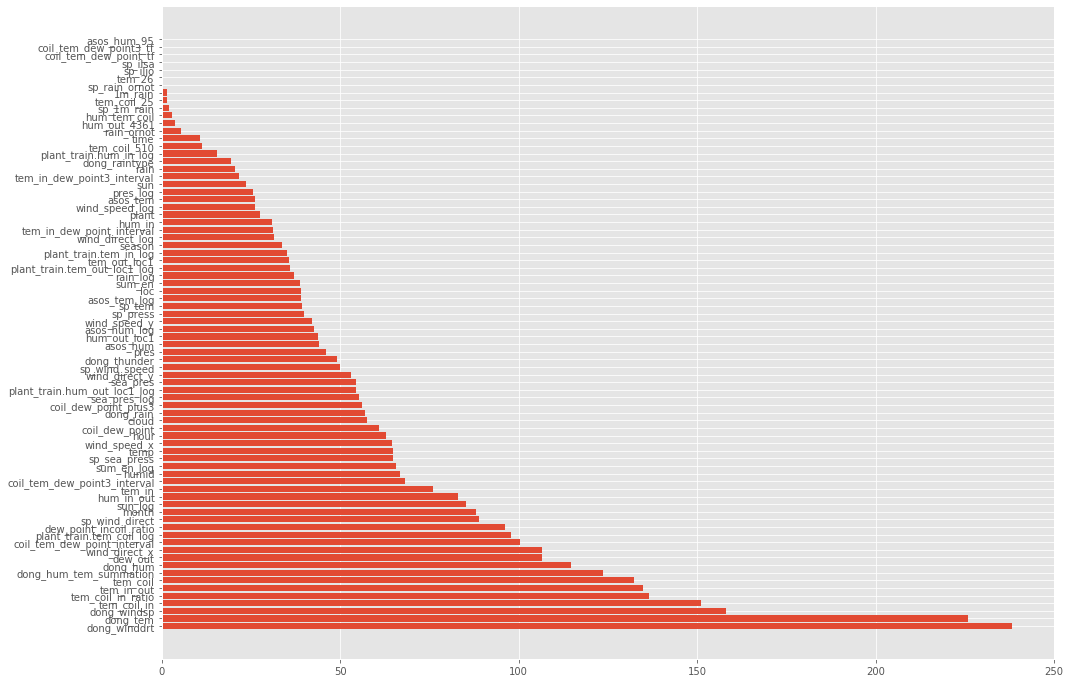

In [90]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999892	training's binary_logloss: 0.0184833	valid_1's auc: 0.998657	valid_1's binary_logloss: 0.0231455
[200]	training's auc: 0.999996	training's binary_logloss: 0.00433178	valid_1's auc: 0.998175	valid_1's binary_logloss: 0.00828577
[300]	training's auc: 1	training's binary_logloss: 0.00135319	valid_1's auc: 0.998476	valid_1's binary_logloss: 0.00552462
[400]	training's auc: 1	training's binary_logloss: 0.0004652	valid_1's auc: 0.998505	valid_1's binary_logloss: 0.00492799
Early stopping, best iteration is:
[132]	training's auc: 0.999955	training's binary_logloss: 0.010886	valid_1's auc: 0.99885	valid_1's binary_logloss: 0.0149548
Fold  1 AUC : 0.998850
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999895	training's binary_logloss: 0.0183357	valid_1's auc: 0.998611	valid_1's binary_logloss: 0.0230463
[200]	training's auc: 0.999999	training's binary_logloss: 0.0

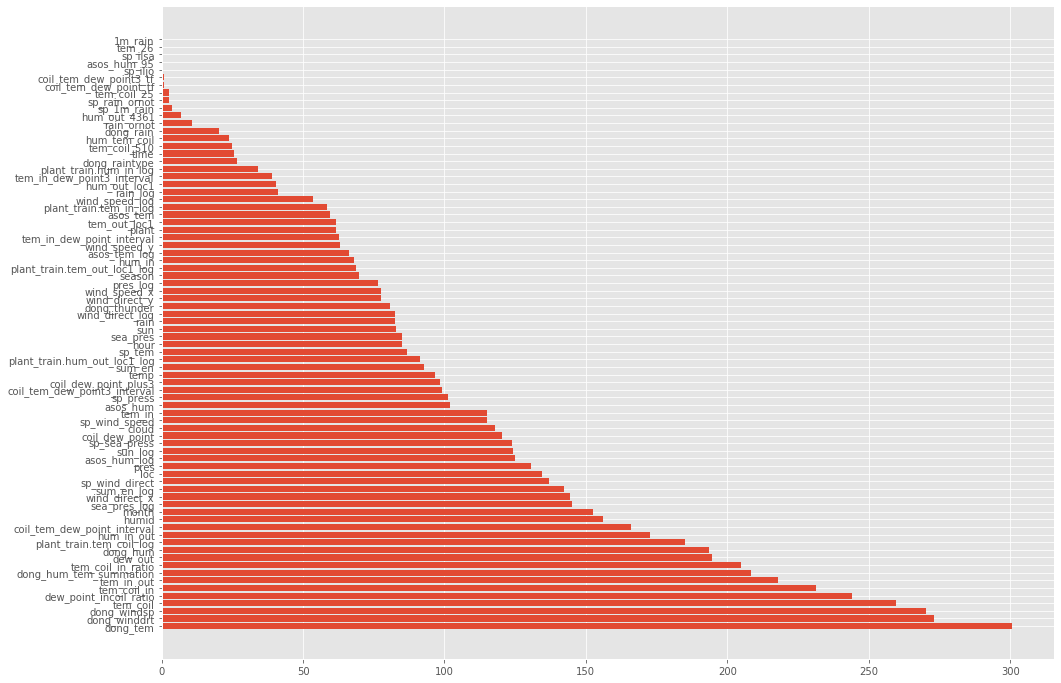

In [91]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

***위의 데이터셋에서 hyper parameter optimazation(Grid search)***

In [45]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.000505878	valid_1's auc: 0.998779	valid_1's binary_logloss: 0.0069003
[200]	training's auc: 1	training's binary_logloss: 4.87573e-05	valid_1's auc: 0.998764	valid_1's binary_logloss: 0.00714699
[300]	training's auc: 1	training's binary_logloss: 2.36923e-05	valid_1's auc: 0.998852	valid_1's binary_logloss: 0.00734088
[400]	training's auc: 1	training's binary_logloss: 1.69436e-05	valid_1's auc: 0.998893	valid_1's binary_logloss: 0.00744462
Early stopping, best iteration is:
[137]	training's auc: 1	training's binary_logloss: 0.000140562	valid_1's auc: 0.998764	valid_1's binary_logloss: 0.00661982
Fold  1 AUC : 0.998764
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.000491302	valid_1's auc: 0.995227	valid_1's binary_logloss: 0.00777005
[200]	training's auc: 1	training's binary_logloss: 5.44762e-05	valid_1's au

In [46]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.00100451	valid_1's auc: 0.998127	valid_1's binary_logloss: 0.00617956
[200]	training's auc: 1	training's binary_logloss: 8.52999e-05	valid_1's auc: 0.998665	valid_1's binary_logloss: 0.00557193
[300]	training's auc: 1	training's binary_logloss: 3.42027e-05	valid_1's auc: 0.998677	valid_1's binary_logloss: 0.00576912
Early stopping, best iteration is:
[41]	training's auc: 0.999901	training's binary_logloss: 0.00942934	valid_1's auc: 0.99882	valid_1's binary_logloss: 0.014277
Fold  1 AUC : 0.998820
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.00106494	valid_1's auc: 0.998874	valid_1's binary_logloss: 0.00606858
[200]	training's auc: 1	training's binary_logloss: 9.32736e-05	valid_1's auc: 0.998748	valid_1's binary_logloss: 0.00650971
[300]	training's auc: 1	training's binary_logloss: 3.56705e-05	valid_1's a

***위의 데이터셋중에서 이슬점 관련 변수까지 파생변수화한 데이터를 다시 검증(하이퍼파라미터는 격자 탐색한 것으로)***

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999943	training's binary_logloss: 0.0114272	valid_1's auc: 0.999189	valid_1's binary_logloss: 0.0159969
[200]	training's auc: 0.999999	training's binary_logloss: 0.00232583	valid_1's auc: 0.999325	valid_1's binary_logloss: 0.00679681
[300]	training's auc: 1	training's binary_logloss: 0.000590323	valid_1's auc: 0.999421	valid_1's binary_logloss: 0.00549729
[400]	training's auc: 1	training's binary_logloss: 0.000174304	valid_1's auc: 0.999438	valid_1's binary_logloss: 0.00542738
[500]	training's auc: 1	training's binary_logloss: 5.17961e-05	valid_1's auc: 0.9994	valid_1's binary_logloss: 0.00580556
[600]	training's auc: 1	training's binary_logloss: 1.64391e-05	valid_1's auc: 0.999465	valid_1's binary_logloss: 0.0061831
Early stopping, best iteration is:
[346]	training's auc: 1	training's binary_logloss: 0.00033637	valid_1's auc: 0.999413	valid_1's binary_logloss: 0.00540219
Fold  1 AUC : 0.999413
Traini

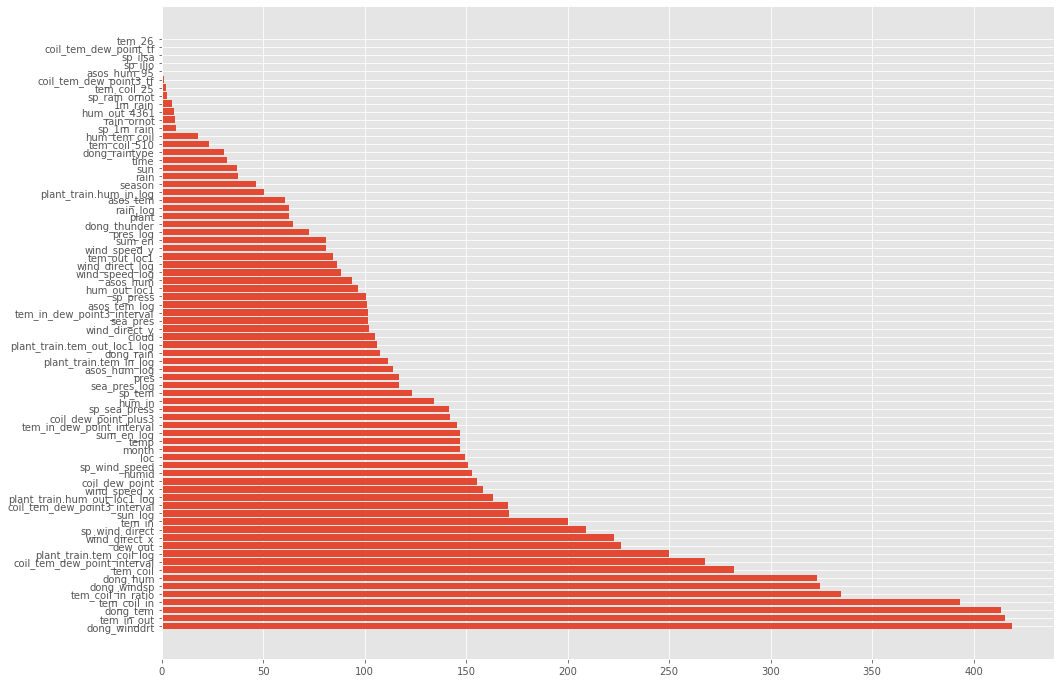

In [75]:
test_preds_lgb24, preds_lgb24, y_test_lgb24, feature_importance_fin_lgb24, conf_matrix_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999891	training's binary_logloss: 0.0197363	valid_1's auc: 0.998743	valid_1's binary_logloss: 0.0242806
[200]	training's auc: 0.999999	training's binary_logloss: 0.00459519	valid_1's auc: 0.996901	valid_1's binary_logloss: 0.00855437
[300]	training's auc: 1	training's binary_logloss: 0.0014465	valid_1's auc: 0.998177	valid_1's binary_logloss: 0.00568788
[400]	training's auc: 1	training's binary_logloss: 0.00049181	valid_1's auc: 0.998608	valid_1's binary_logloss: 0.0049813
Early stopping, best iteration is:
[116]	training's auc: 0.999935	training's binary_logloss: 0.015261	valid_1's auc: 0.998796	valid_1's binary_logloss: 0.019658
Fold  1 AUC : 0.998796
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999883	training's binary_logloss: 0.01951	valid_1's auc: 0.997891	valid_1's binary_logloss: 0.0251278
[200]	training's auc: 0.999998	training's binary_logloss: 0.0046

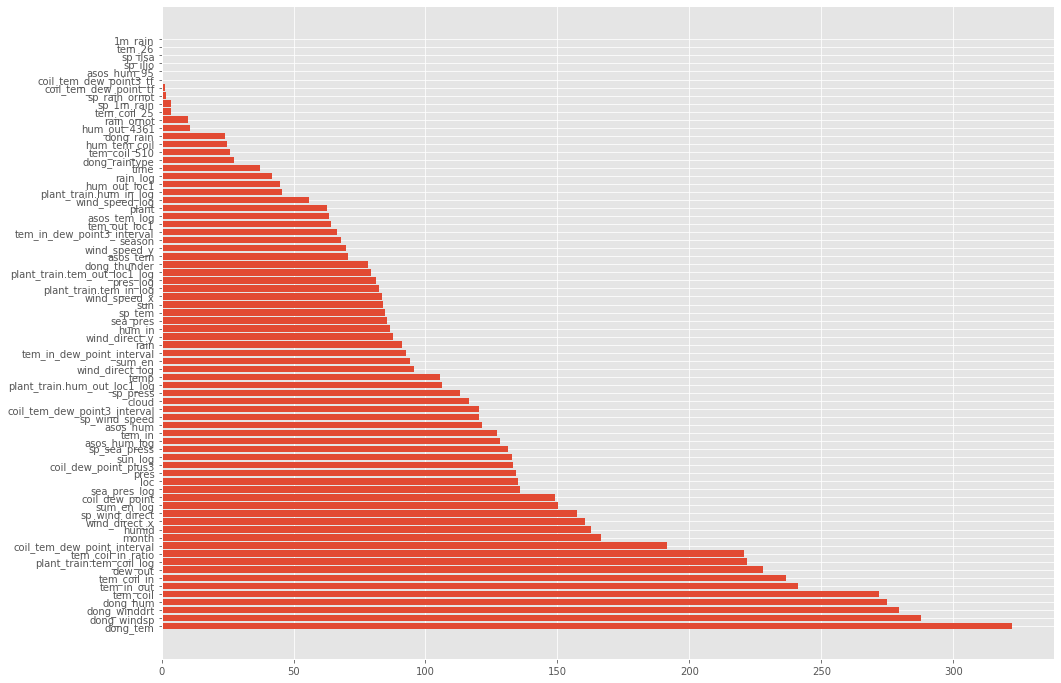

In [76]:
test_preds_lgb48, preds_lgb48, y_test_lgb48, feature_importance_fin_lgb48, conf_matrix_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

#### ***LGBM 실제 훈련***

***베이스 데이터셋 + cutoff0.5 + 결측치 처리 x***

In [18]:
test_preds_lgb24, preds_lgb24, feature_importance_fin_lgb24 = LGBM_classifier(\
                                                                                df24,
                                                                                test_df,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.62,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999795	training's binary_logloss: 0.0237125	valid_1's auc: 0.998072	valid_1's binary_logloss: 0.0294243
[200]	training's auc: 0.999975	training's binary_logloss: 0.00655583	valid_1's auc: 0.998659	valid_1's binary_logloss: 0.0101273
[300]	training's auc: 0.999997	training's binary_logloss: 0.00259335	valid_1's auc: 0.998359	valid_1's binary_logloss: 0.00654203
[400]	training's auc: 1	training's binary_logloss: 0.0010692	valid_1's auc: 0.99849	valid_1's binary_logloss: 0.00518729
Early stopping, best iteration is:
[164]	training's auc: 0.999945	training's binary_logloss: 0.00987261	valid_1's auc: 0.998667	valid_1's binary_logloss: 0.0136201
Fold  1 AUC : 0.998667
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999831	training's binary_logloss: 0.0222699	valid_1's auc: 0.996968	valid_1's binary_logloss: 0.0267014
[200]	training's auc: 0.999982	training's binary_logl

In [19]:
test_preds_lgb48, preds_lgb48, feature_importance_fin_lgb48 = LGBM_classifier(\
                                                                                df48,
                                                                                test_df,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.62,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999744	training's binary_logloss: 0.0325662	valid_1's auc: 0.996817	valid_1's binary_logloss: 0.0379514
[200]	training's auc: 0.999966	training's binary_logloss: 0.00991389	valid_1's auc: 0.997471	valid_1's binary_logloss: 0.013187
[300]	training's auc: 0.999994	training's binary_logloss: 0.0037289	valid_1's auc: 0.998013	valid_1's binary_logloss: 0.00725193
[400]	training's auc: 1	training's binary_logloss: 0.00159576	valid_1's auc: 0.998174	valid_1's binary_logloss: 0.00553748
[500]	training's auc: 1	training's binary_logloss: 0.000726538	valid_1's auc: 0.997929	valid_1's binary_logloss: 0.00504646
[600]	training's auc: 1	training's binary_logloss: 0.000354206	valid_1's auc: 0.997777	valid_1's binary_logloss: 0.00511453
[700]	training's auc: 1	training's binary_logloss: 0.000168604	valid_1's auc: 0.997728	valid_1's binary_logloss: 0.0051715
Early stopping, best iteration is:
[406]	training's auc: 1	

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o***

In [300]:
test_preds_lgb24, preds_lgb24, feature_importance_fin_lgb24 = LGBM_classifier(\
                                                                                train_24,
                                                                                dj_ts_aws,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.9999	training's binary_logloss: 0.0133785	valid_1's auc: 0.998749	valid_1's binary_logloss: 0.0188647
[200]	training's auc: 0.999997	training's binary_logloss: 0.00334227	valid_1's auc: 0.992956	valid_1's binary_logloss: 0.00939306
[300]	training's auc: 1	training's binary_logloss: 0.00108943	valid_1's auc: 0.994056	valid_1's binary_logloss: 0.00733141
[400]	training's auc: 1	training's binary_logloss: 0.0004082	valid_1's auc: 0.994306	valid_1's binary_logloss: 0.00700808
Early stopping, best iteration is:
[147]	training's auc: 0.999964	training's binary_logloss: 0.0064783	valid_1's auc: 0.999017	valid_1's binary_logloss: 0.0111994
Fold  1 AUC : 0.999017
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999901	training's binary_logloss: 0.0140076	valid_1's auc: 0.999045	valid_1's binary_logloss: 0.0176722
[200]	training's auc: 0.999995	training's binary_logloss: 0.0

In [301]:
test_preds_lgb48, preds_lgb48, feature_importance_fin_lgb48 = LGBM_classifier(\
                                                                                train_48,
                                                                                dj_ts_aws,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999811	training's binary_logloss: 0.0251716	valid_1's auc: 0.999328	valid_1's binary_logloss: 0.0291062
[200]	training's auc: 0.999979	training's binary_logloss: 0.0070497	valid_1's auc: 0.999333	valid_1's binary_logloss: 0.00986489
[300]	training's auc: 0.999999	training's binary_logloss: 0.00256147	valid_1's auc: 0.999469	valid_1's binary_logloss: 0.00600898
[400]	training's auc: 1	training's binary_logloss: 0.0010109	valid_1's auc: 0.999542	valid_1's binary_logloss: 0.00465828
[500]	training's auc: 1	training's binary_logloss: 0.000449401	valid_1's auc: 0.999551	valid_1's binary_logloss: 0.00435488
[600]	training's auc: 1	training's binary_logloss: 0.000192355	valid_1's auc: 0.999478	valid_1's binary_logloss: 0.00427863
[700]	training's auc: 1	training's binary_logloss: 8.70634e-05	valid_1's auc: 0.999535	valid_1's binary_logloss: 0.0043231
[800]	training's auc: 1	training's binary_logloss: 3.90044

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o + 이슬점관련 변수***

In [455]:
test_preds_lgb24, preds_lgb24, feature_importance_fin_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999921	training's binary_logloss: 0.012545	valid_1's auc: 0.999025	valid_1's binary_logloss: 0.0180049
[200]	training's auc: 0.999995	training's binary_logloss: 0.00300028	valid_1's auc: 0.99299	valid_1's binary_logloss: 0.00830432
[300]	training's auc: 1	training's binary_logloss: 0.000914063	valid_1's auc: 0.994236	valid_1's binary_logloss: 0.00641712
[400]	training's auc: 1	training's binary_logloss: 0.000313514	valid_1's auc: 0.994537	valid_1's binary_logloss: 0.00612611
Early stopping, best iteration is:
[106]	training's auc: 0.999933	training's binary_logloss: 0.0112854	valid_1's auc: 0.999079	valid_1's binary_logloss: 0.0165337
Fold  1 AUC : 0.999079
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999891	training's binary_logloss: 0.0134641	valid_1's auc: 0.998806	valid_1's binary_logloss: 0.0170513
[200]	training's auc: 0.999994	training's binary_logloss: 

In [456]:
test_preds_lgb48, preds_lgb48, feature_importance_fin_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999836	training's binary_logloss: 0.0233797	valid_1's auc: 0.999217	valid_1's binary_logloss: 0.0270064
[200]	training's auc: 0.999977	training's binary_logloss: 0.00644771	valid_1's auc: 0.999559	valid_1's binary_logloss: 0.00918416
[300]	training's auc: 0.999999	training's binary_logloss: 0.00224399	valid_1's auc: 0.996967	valid_1's binary_logloss: 0.00612683
[400]	training's auc: 1	training's binary_logloss: 0.000912544	valid_1's auc: 0.996907	valid_1's binary_logloss: 0.00521375
[500]	training's auc: 1	training's binary_logloss: 0.000377887	valid_1's auc: 0.996874	valid_1's binary_logloss: 0.00494695
Early stopping, best iteration is:
[206]	training's auc: 0.999979	training's binary_logloss: 0.00602292	valid_1's auc: 0.999575	valid_1's binary_logloss: 0.00880414
Fold  1 AUC : 0.999575
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.99985	training's binary_logl

***베이스 데이터셋 + 신평 + 동네예보 + cutoff0.5 + 결측치 처리 o + 이슬점 + 시간관련 데이터+습도기술통계량***

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999903	training's binary_logloss: 0.0120664	valid_1's auc: 0.999057	valid_1's binary_logloss: 0.0170211
[200]	training's auc: 0.999995	training's binary_logloss: 0.00279535	valid_1's auc: 0.998168	valid_1's binary_logloss: 0.00751993
[300]	training's auc: 1	training's binary_logloss: 0.000844595	valid_1's auc: 0.998717	valid_1's binary_logloss: 0.0057797
[400]	training's auc: 1	training's binary_logloss: 0.000285	valid_1's auc: 0.998984	valid_1's binary_logloss: 0.00554691
Early stopping, best iteration is:
[154]	training's auc: 0.999973	training's binary_logloss: 0.00526594	valid_1's auc: 0.999244	valid_1's binary_logloss: 0.00935167
Fold  1 AUC : 0.999244
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.99991	training's binary_logloss: 0.0128543	valid_1's auc: 0.998646	valid_1's binary_logloss: 0.0160296
[200]	training's auc: 0.999993	training's binary_logloss: 0

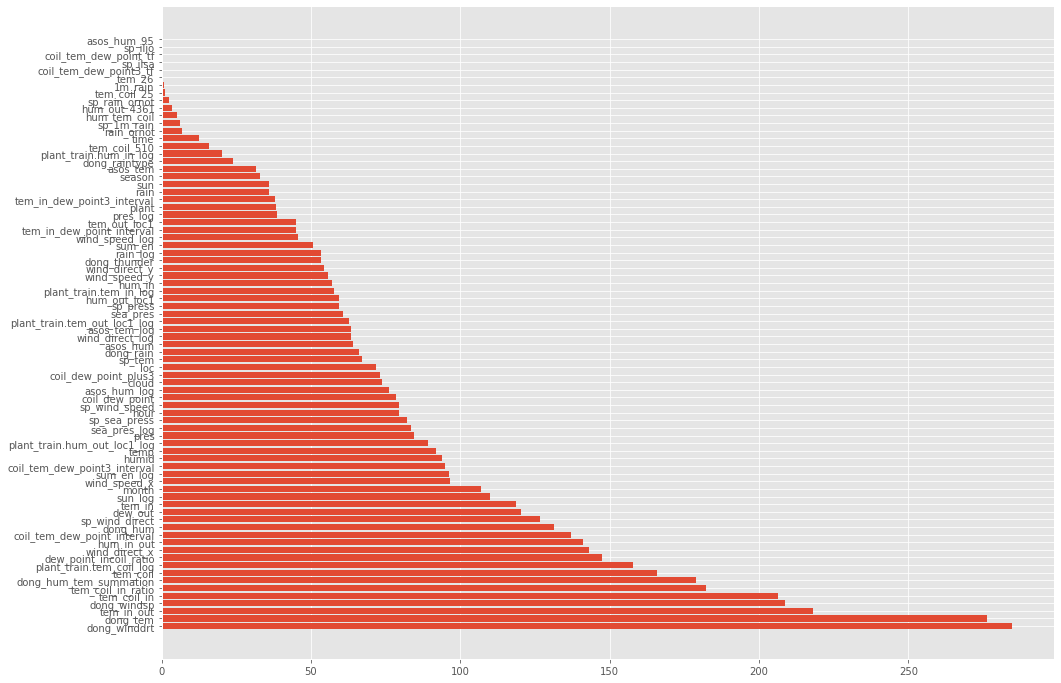

In [97]:
test_preds_lgb24, preds_lgb24, feature_importance_fin_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.99986	training's binary_logloss: 0.021745	valid_1's auc: 0.999341	valid_1's binary_logloss: 0.0253761
[200]	training's auc: 0.999987	training's binary_logloss: 0.00590511	valid_1's auc: 0.99822	valid_1's binary_logloss: 0.00875014
[300]	training's auc: 0.999999	training's binary_logloss: 0.00207972	valid_1's auc: 0.99901	valid_1's binary_logloss: 0.00548605
[400]	training's auc: 1	training's binary_logloss: 0.000806634	valid_1's auc: 0.999269	valid_1's binary_logloss: 0.00450272
Early stopping, best iteration is:
[185]	training's auc: 0.999978	training's binary_logloss: 0.00697725	valid_1's auc: 0.9996	valid_1's binary_logloss: 0.00968705
Fold  1 AUC : 0.999600
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999877	training's binary_logloss: 0.0194332	valid_1's auc: 0.996174	valid_1's binary_logloss: 0.0254277
[200]	training's auc: 0.999994	training's binary_loglo

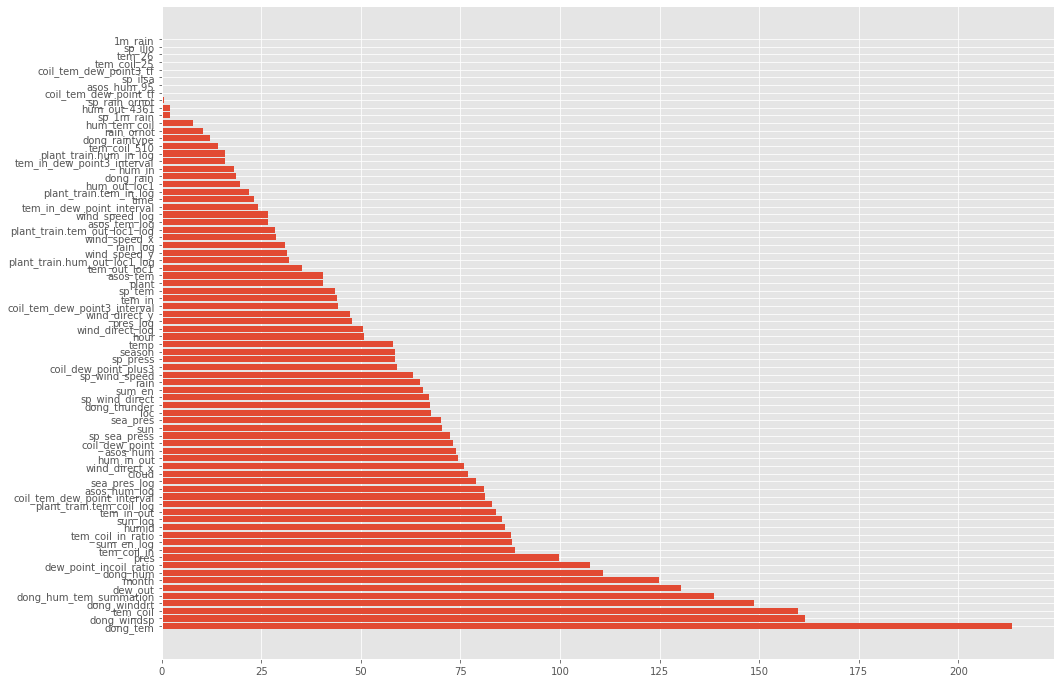

In [98]:
test_preds_lgb48, preds_lgb48, feature_importance_fin_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

***grid search2 model***

In [194]:
test_preds_lgb24, preds_lgb24, feature_importance_fin_lgb24 = LGBM_classifier(\
                                                                                train_24_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.000578527	valid_1's auc: 0.998988	valid_1's binary_logloss: 0.00628735
Did not meet early stopping. Best iteration is:
[97]	training's auc: 1	training's binary_logloss: 0.000630968	valid_1's auc: 0.999025	valid_1's binary_logloss: 0.00628027
Fold  1 AUC : 0.999025
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.000797296	valid_1's auc: 0.998151	valid_1's binary_logloss: 0.00605864
Did not meet early stopping. Best iteration is:
[99]	training's auc: 1	training's binary_logloss: 0.00080935	valid_1's auc: 0.998147	valid_1's binary_logloss: 0.00605943
Fold  2 AUC : 0.998147
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 1	training's binary_logloss: 0.000742001	valid_1's auc: 0.998649	valid_1's binary_logloss: 0.00545661
Did not meet early stopping. Best iteration is:
[89]	tr

In [195]:
test_preds_lgb48, preds_lgb48, feature_importance_fin_lgb48 = LGBM_classifier(\
                                                                                train_48_recent,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = True)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999998	training's binary_logloss: 0.00135761	valid_1's auc: 0.999214	valid_1's binary_logloss: 0.0053022
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.999998	training's binary_logloss: 0.00135761	valid_1's auc: 0.999214	valid_1's binary_logloss: 0.0053022
Fold  1 AUC : 0.999214
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999999	training's binary_logloss: 0.00134214	valid_1's auc: 0.992726	valid_1's binary_logloss: 0.0070001
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.999999	training's binary_logloss: 0.00134214	valid_1's auc: 0.992726	valid_1's binary_logloss: 0.0070001
Fold  2 AUC : 0.992726
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.999996	training's binary_logloss: 0.00150842	valid_1's auc: 0.998874	valid_1's binary_logloss: 0.00624844
Did not meet early stoppin

### ***LGBM Grid Search***

In [180]:
# A parameter grid for XGBoost
lgb_params = {
        'min_child_weight': [0.5],
        'gamma': [0.4],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'max_depth': [5],
        'learning_rate' : [0.6]
        }

#24시간 뒤의 결로현상을 예측하는 교차 모델
param_comb = 5
n = 5

X = train_24_recent.drop(columns = 'after24_loc_predict')
Y = train_24_recent['after24_loc_predict']

folds= KFold(n_splits=n, shuffle = True, random_state = 1001)
lgb_clf = lgb.LGBMClassifier(n_estimaters = 1000, class_weight='balanced')

random_search_lgb = RandomizedSearchCV(lgb_clf, param_distributions=lgb_params, n_iter=param_comb, scoring='roc_auc', n_jobs=1, cv=folds.split(X,Y), verbose=10, random_state=1001 )

# Here we go
start_time = time.time() # timing starts from this point for "start_time" variable
random_search_lgb.fit(X, Y)
print('걸린 시간 : ', time.time() - start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8, score=0.999, total=   2.5s
[CV] subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8, score=0.998, total=   2.4s
[CV] subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8, score=0.999, total=   2.4s
[CV] subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.3s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8, score=0.999, total=   2.4s
[CV] subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.7s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=0.5, max_depth=5, learning_rate=0.6, gamma=0.4, colsample_bytree=0.8, score=0.999, total=   2.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.2s finished


걸린 시간 :  14.72834587097168


In [173]:
print('------------------------------------')
print(lgb_params)
print('------------------------------------')
print(random_search_lgb.best_estimator_)
print('------------------------------------')
print(random_search_lgb.best_params_)
print('------------------------------------')
print(random_search_lgb.best_score_)
print('------------------------------------')

------------------------------------
{'min_child_weight': [0.4, 0.5, 0.6], 'gamma': [0.4, 0.5, 1], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9], 'max_depth': [4.5, 5, 5.5], 'learning_rate': [0.5, 0.6, 0.7]}
------------------------------------
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, gamma=0.4, importance_type='split',
               learning_rate=0.6, max_depth=5, min_child_samples=20,
               min_child_weight=0.6, min_split_gain=0.0, n_estimaters=1000,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)
------------------------------------
{'subsample': 0.8, 'min_child_weight': 0.6, 'max_depth': 5, 'learning_rate': 0.6, 'gamma': 0.4, 'colsample_bytree': 0.8}
------------------------------------
0.9986900035152282
--------------

In [177]:
print('------------------------------------')
print(lgb_params)
print('------------------------------------')
print(random_search_lgb.best_estimator_)
print('------------------------------------')
print(random_search_lgb.best_params_)
print('------------------------------------')
print(random_search_lgb.best_score_)
print('------------------------------------')

------------------------------------
{'min_child_weight': [0.5, 0.6, 0.7], 'gamma': [0.3, 0.4, 0.45], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9], 'max_depth': [4.5, 5, 5.5], 'learning_rate': [0.5, 0.6, 0.7]}
------------------------------------
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.9, gamma=0.3, importance_type='split',
               learning_rate=0.6, max_depth=5, min_child_samples=20,
               min_child_weight=0.6, min_split_gain=0.0, n_estimaters=1000,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)
------------------------------------
{'subsample': 0.8, 'min_child_weight': 0.6, 'max_depth': 5, 'learning_rate': 0.6, 'gamma': 0.3, 'colsample_bytree': 0.9}
------------------------------------
0.9986602127319225
-----------

In [181]:
print('------------------------------------')
print(lgb_params)
print('------------------------------------')
print(random_search_lgb.best_estimator_)
print('------------------------------------')
print(random_search_lgb.best_params_)
print('------------------------------------')
print(random_search_lgb.best_score_)
print('------------------------------------')

------------------------------------
{'min_child_weight': [0.5], 'gamma': [0.4], 'subsample': [0.8], 'colsample_bytree': [0.8], 'max_depth': [5], 'learning_rate': [0.6]}
------------------------------------
LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, gamma=0.4, importance_type='split',
               learning_rate=0.6, max_depth=5, min_child_samples=20,
               min_child_weight=0.5, min_split_gain=0.0, n_estimaters=1000,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)
------------------------------------
{'subsample': 0.8, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.6, 'gamma': 0.4, 'colsample_bytree': 0.8}
------------------------------------
0.9987418247005454
------------------------------------


## ***Feature importance***

<BarContainer object of 48 artists>

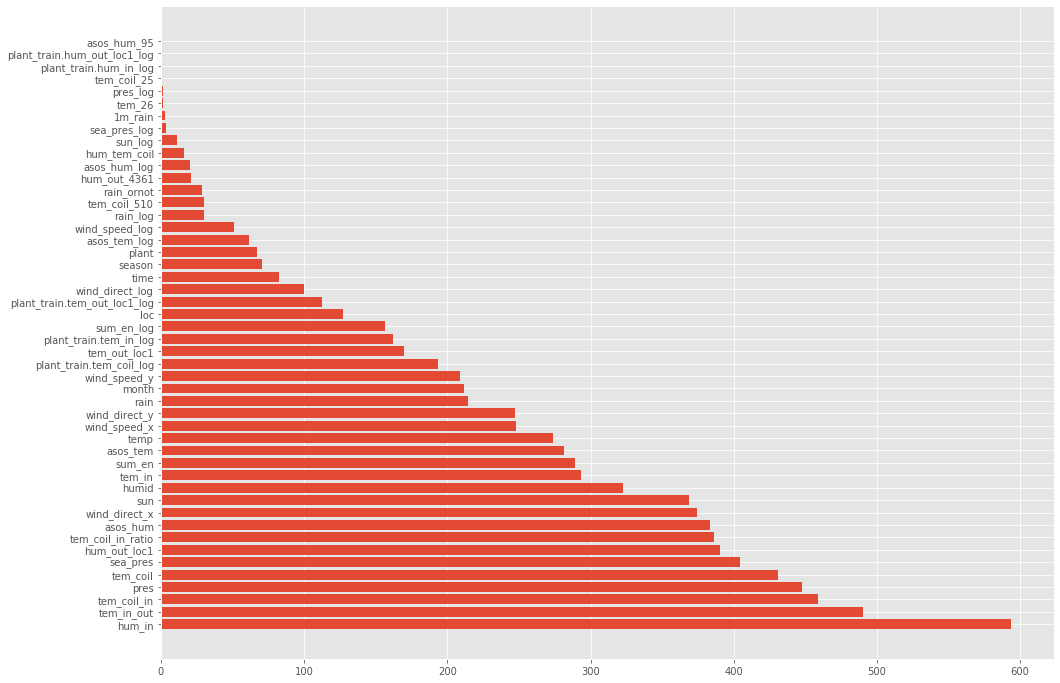

In [63]:
plt.figure(figsize = (16,12))
plt.barh(feature_importance_fin_lgb24.index,feature_importance_fin_lgb24['importance'])

#### ***이슬점관련된 변수들 추가한 변수중요도***

<BarContainer object of 74 artists>

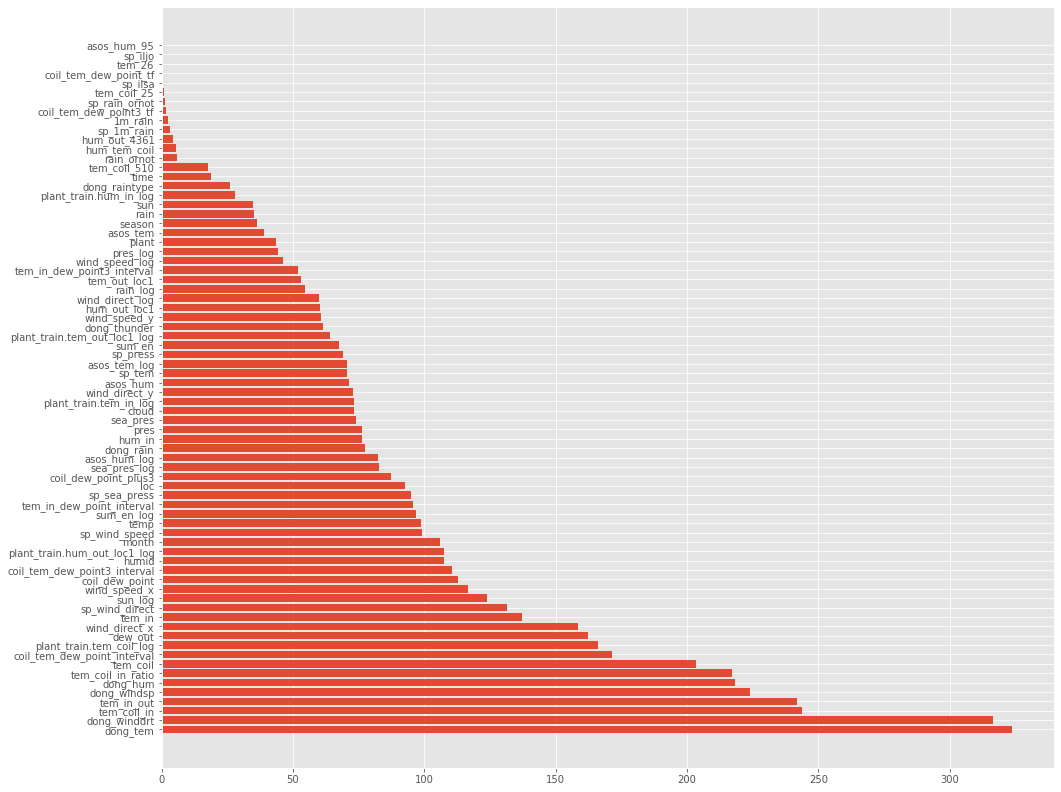

In [375]:
plt.figure(figsize = (16,14))
plt.barh(feature_importance_fin_lgb24.index,feature_importance_fin_lgb24['importance'])

<BarContainer object of 74 artists>

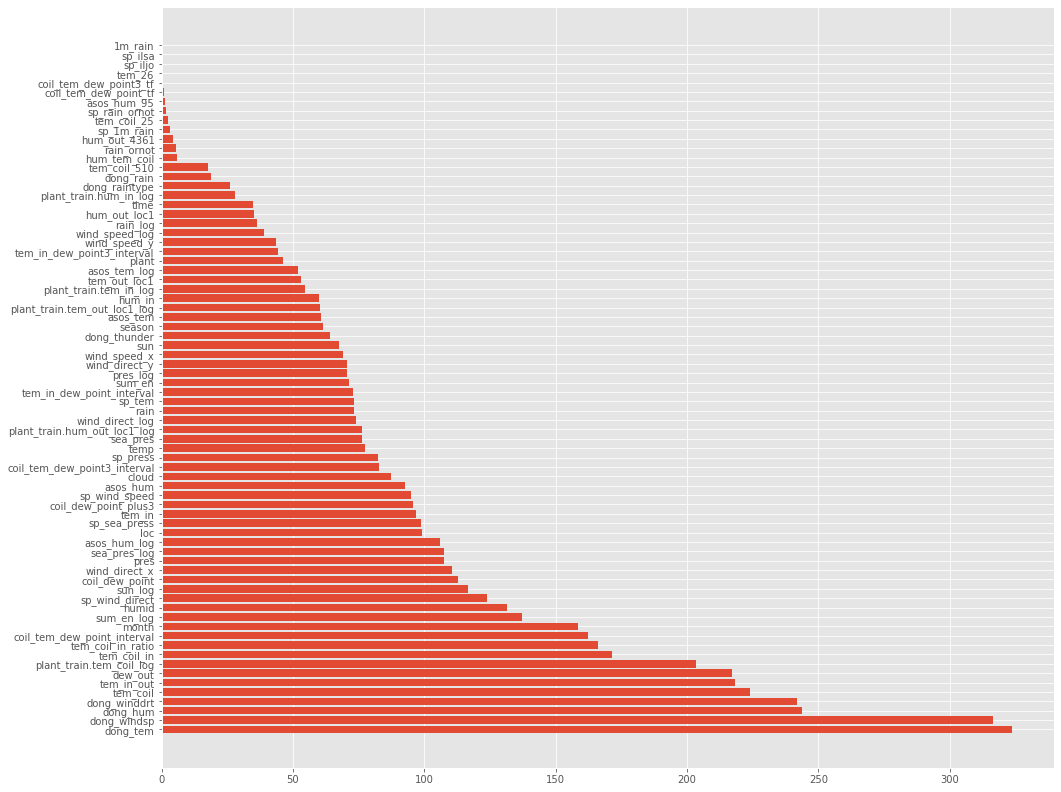

In [376]:
plt.figure(figsize = (16,14))
plt.barh(feature_importance_fin_lgb48.index,feature_importance_fin_lgb24['importance'])

<BarContainer object of 74 artists>

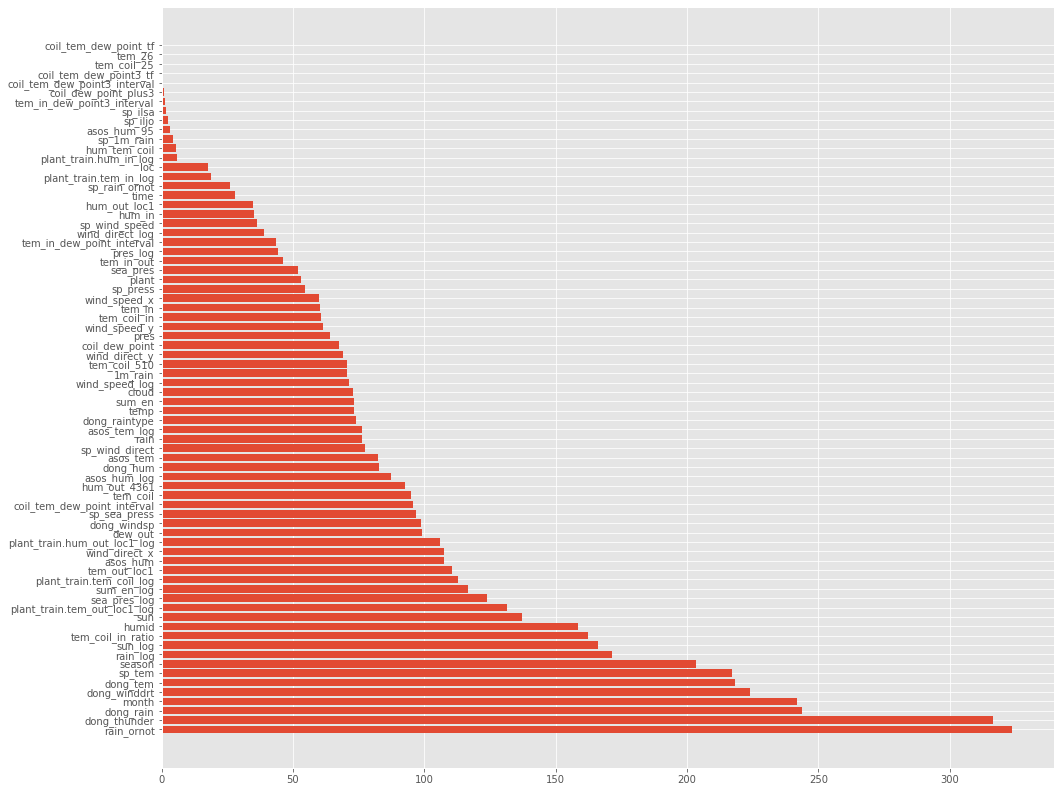

In [377]:
plt.figure(figsize = (16,14))
plt.barh(feature_importance_fin_xgb24.index,feature_importance_fin_lgb24['importance'])

<BarContainer object of 74 artists>

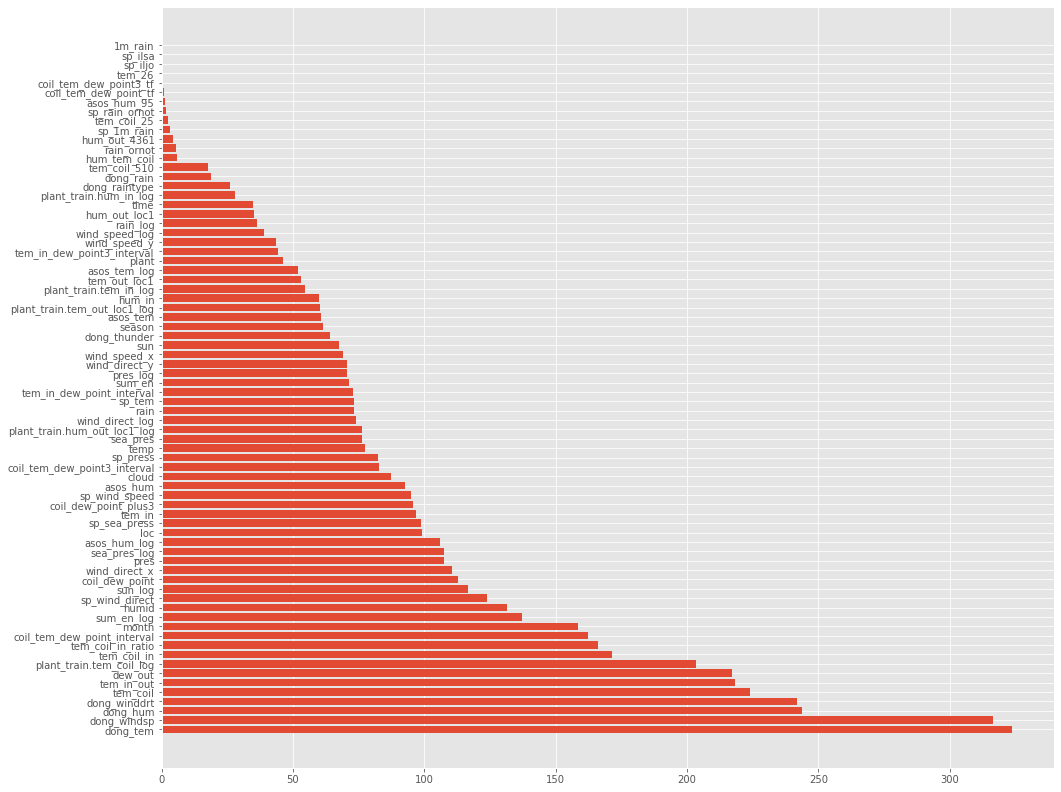

In [378]:
plt.figure(figsize = (16,14))
plt.barh(feature_importance_fin_lgb48.index,feature_importance_fin_lgb24['importance'])

***hyper parameter 조정한 변수중요도***

<BarContainer object of 74 artists>

findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.


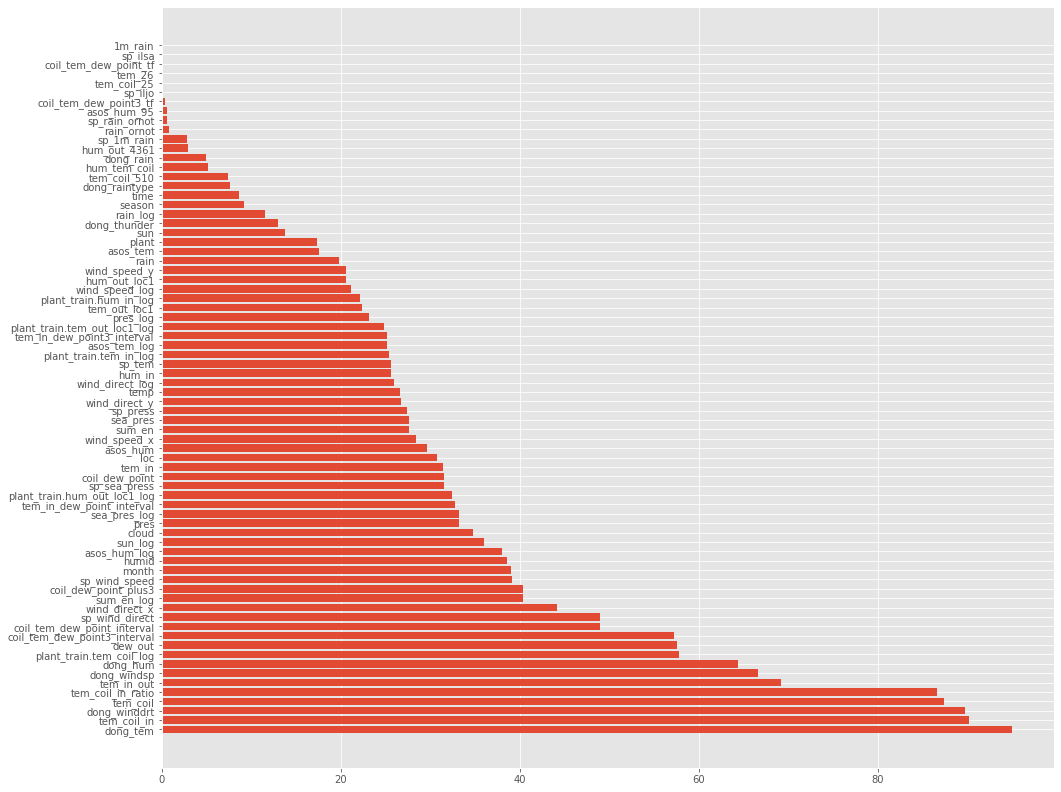

In [67]:
plt.figure(figsize = (16,14))
plt.barh(feature_importance_fin_lgb48.index,feature_importance_fin_lgb24['importance'])

<BarContainer object of 74 artists>

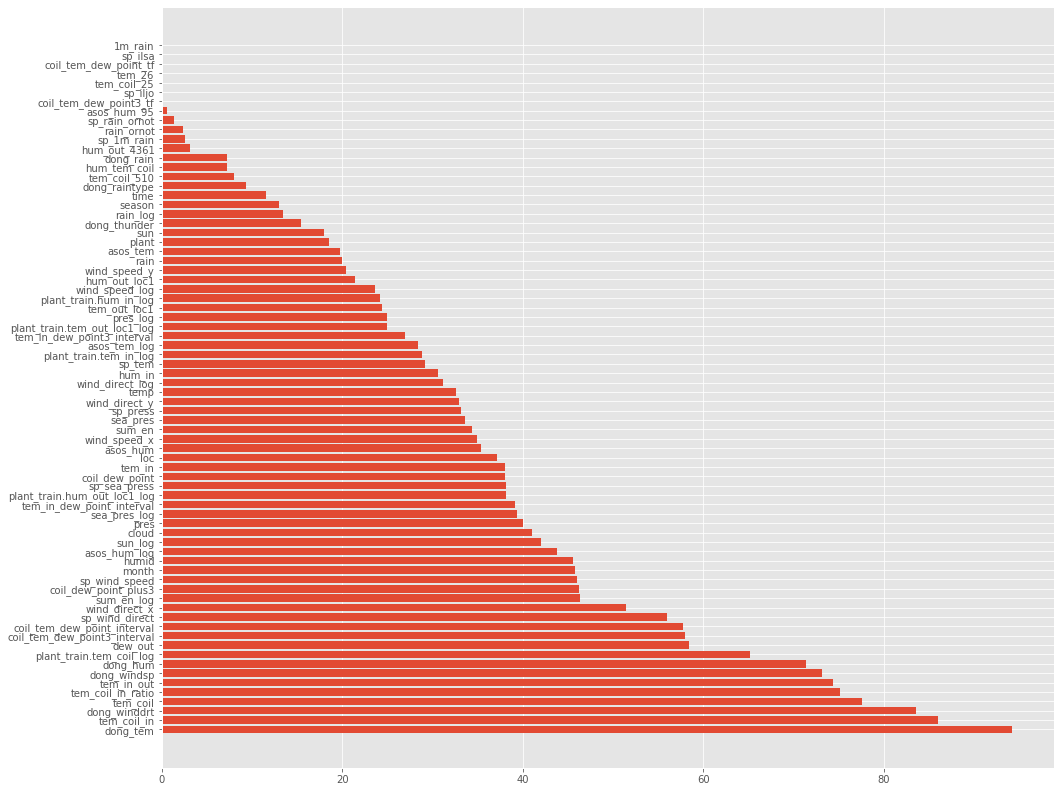

In [68]:
plt.figure(figsize = (16,14))
plt.barh(feature_importance_fin_lgb48.index,feature_importance_fin_lgb48['importance'])

# 5. GBM

# 6. Cat Boost

# 7. RF

In [441]:
train_24_recent_rf = train_24_recent.fillna(-999)
train_48_recent_rf = train_48_recent.fillna(-999)

In [442]:
def rf_classifier(df, test_df, target_variable, num_folds,cut_off , real_train = False):
    if real_train == False:
        X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target_variable),df[target_variable],test_size = 0.25, random_state = 0)
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
        
        oof_preds = np.zeros(X_train.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        
        feature_importance_df = pd.DataFrame()
        
        for folds_, (train_idx,valid_idx) in enumerate(folds.split(X_train,y_train)):

            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            clf_rf = RandomForestClassifier(class_weight = 'balanced',n_estimators=1000)

            clf_rf.fit(train_x,train_y)

            oof_preds[valid_idx] = clf_rf.predict(valid_x)
            test_preds += clf_rf.predict_proba(X_test)[:,1] / folds.n_splits

            clf_rf.feature_importances_

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf_rf.feature_importances_
            fold_importance_df["fold"] = folds_ + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            print('Fold %2d AUC : %.6f' % (folds_ + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

            del clf_rf, train_x, train_y, valid_x, valid_y
            gc.collect()

        print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))

        feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                                groupby("feature").mean().sort_values(by="importance", ascending=False)
        
        preds = []

        for i in range(len(test_preds)):
            if test_preds[i] >= cut_off:

                preds.append(1)
            else:
                preds.append(0)

        print('Test AUC score : ', roc_auc_score(y_test, test_preds))
        conf_matrix = confusion_matrix(y_test, preds,labels = [1,0])
        
        return test_preds, preds, y_test, feature_importance_fin, conf_matrix


In [444]:
test_preds_rf24, preds_rf24, y_test_rf24, feature_importance_fin_rf24, conf_matrix_rf24 = rf_classifier(\
                                                                                train_24_recent_rf,
                                                                                dj_ts_aws_recent,
                                                                                'after24_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Fold  1 AUC : 0.866762
Fold  2 AUC : 0.876817
Fold  3 AUC : 0.837951
Fold  4 AUC : 0.874884
Fold  5 AUC : 0.863227
Full AUC score 0.863745
Test AUC score :  0.9994422704049081


In [445]:
test_preds_rf48, preds_rf48, y_test_rf48, feature_importance_fin_rf48, conf_matrix_rf48 = rf_classifier(\
                                                                                train_48_recent_rf,
                                                                                dj_ts_aws_recent,
                                                                                'after48_loc_predict',
                                                                                5,
                                                                                0.5,
                                                                                real_train = False)

Fold  1 AUC : 0.877017
Fold  2 AUC : 0.864429
Fold  3 AUC : 0.865749
Fold  4 AUC : 0.874855
Fold  5 AUC : 0.867670
Full AUC score 0.869795
Test AUC score :  0.9958731547530112


## ***Ensemble***

#### 검증데이터

In [65]:
def proba_to_int(value_ls,cut_off):
    
    preds = []
    for i in range(len(value_ls)):
        
        if value_ls[i] >= cut_off:
            preds.append(1)
        else:
            preds.append(0)
            
            
    return preds

#proba 데이터를 넣어줘야함
def validation_emd(lgb24,lgb48,xgb24,xgb48,y_test24,y_test48,cut_off):
    lgb24 = lgb24
    xgb24 = xgb24

    lgb48 = lgb48
    xgb48 = xgb48

    lgb_xgb_emb24 = (lgb24 + xgb24) / 2
    lgb_xgb_emb48 = (lgb48 + xgb48) / 2

    emb24_pred = proba_to_int(lgb_xgb_emb24,cut_off)
    emb48_pred = proba_to_int(lgb_xgb_emb48,cut_off)
    
    print('After 24 hour predict auc : ',roc_auc_score(y_test24,emb24_pred))
    print('After 24 hour proba auc : ',roc_auc_score(y_test24,lgb_xgb_emb24))
    
    print('\nAfter 48 hour predict auc : ',roc_auc_score(y_test48,emb48_pred))
    print('After 48 hour proba auc : ',roc_auc_score(y_test48,lgb_xgb_emb48))
    
    
    conf_matrix24 = confusion_matrix(y_test24,emb24_pred,labels = [1,0])
    conf_matrix48 = confusion_matrix(y_test48,emb48_pred,labels = [1,0])
    print('\nCut Off : ', cut_off)
    print('\nAfter 24hour confusion matrix : \n',conf_matrix24)
    print('\nAfter 48hour confusion matrix : \n',conf_matrix48)
    
    
    csi24 = conf_matrix24[0,0] / (conf_matrix24[0,0] + conf_matrix24[0,1] + conf_matrix24[1,0])
    csi48 = conf_matrix48[0,0] / (conf_matrix48[0,0] + conf_matrix48[0,1] + conf_matrix48[1,0])
    
    print('\nAfter 24hour CSI : ', csi24)
    print('\nAfter 48hour CSI : ', csi48)
    return emb24_pred, emb48_pred

def validation_emd2(lgb24,lgb48,xgb24,xgb48,rf24,rf48,y_test24,y_test48,n):
    lgb24 = lgb24
    xgb24 = xgb24
    rf24 = rf24

    lgb48 = lgb48
    xgb48 = xgb48
    rf48 = rf48

    emb24 = (lgb24 + xgb24 + rf24) / n
    emb48 = (lgb48 + xgb48 + rf48) / n

    emb24_pred = proba_to_int(emb24)
    emb48_pred = proba_to_int(emb48)
    
    conf_matrix24 = confusion_matrix(y_test24,emb24_pred,labels = [1,0])
    conf_matrix48 = confusion_matrix(y_test48,emb48_pred,labels = [1,0])
    
    
    print('After 24hour confusion matrix : \n',conf_matrix24)
    print('\nAfter 48hour confusion matrix : \n',conf_matrix48)
    
    csi24 = conf_matrix24[0,0] / (conf_matrix24[0,0] + conf_matrix24[0,1] + conf_matrix24[1,0])
    csi48 = conf_matrix48[0,0] / (conf_matrix48[0,0] + conf_matrix48[0,1] + conf_matrix48[1,0])
    
    print('\nAfter 24hour CSI : ', csi24)
    print('\nAfter 48hour CSI : ', csi48)
    return emb24_pred, emb48_pred

In [42]:
emb24_pred, emb48_pred, csi24, csi48 = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48)

In [48]:
#lgb cutoff 0.62 / xgb 0.5
print('After 24hour confusion matrix : \n',confusion_matrix(y_test_lgb24,emb24_pred))
print('\nAfter 48hour confusion matrix : \n',confusion_matrix(y_test_lgb48,emb48_pred))

After 24hour confusion matrix : 
 [[85973    48]
 [   60   421]]

After 48hour confusion matrix : 
 [[85618    67]
 [   59   430]]


In [238]:
#lgb cutoff 0.5 / xgb 0.5
#cut off를 조정해도 크게 변하지 않음
#결측치를 처리하지 않은 base 데이터
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48)

After 24hour confusion matrix : 
 [[  421    60]
 [   48 85973]]

After 48hour confusion matrix : 
 [[  430    59]
 [   67 85618]]

After 24hour CSI :  0.7958412098298677

After 48hour CSI :  0.7733812949640287


In [57]:
#lgb cutoff 0.4 / xgb 0.5
#cut off를 조정해도 크게 변하지 않음
#결측치를 처리하지 않은 base 데이터
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48)

After 24hour confusion matrix : 
 [[  421    60]
 [   48 85973]]

After 48hour confusion matrix : 
 [[  430    59]
 [   67 85618]]

After 24hour CSI :  0.7958412098298677

After 48hour CSI :  0.7733812949640287


In [132]:
#lgb cutoff 0.5 / xgb 0.5
#결측치를 처리한 base 데이터
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48)

After 24hour confusion matrix : 
 [[  434    65]
 [   66 86423]]

After 48hour confusion matrix : 
 [[  436    66]
 [   46 86161]]

After 24hour CSI :  0.768141592920354

After 48hour CSI :  0.7956204379562044


In [161]:
#결측치 처리x + 신평aws + 동네예보
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48)

After 24hour confusion matrix : 
 [[  432    67]
 [   58 86431]]

After 48hour confusion matrix : 
 [[  441    61]
 [   47 86160]]

After 24hour CSI :  0.7755834829443446

After 48hour CSI :  0.8032786885245902


In [230]:
#결측치 처리 + 신평aws + 동네예보
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48)

After 24hour confusion matrix : 
 [[  437    62]
 [   65 86424]]

After 48hour confusion matrix : 
 [[  436    66]
 [   30 86177]]

After 24hour CSI :  0.774822695035461

After 48hour CSI :  0.8195488721804511


In [422]:
#이슬점(asos, 코일로 구한 이슬점)변수 추가 / 이슬점과 관련된 변수들
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48)

After 24hour confusion matrix : 
 [[  441    58]
 [   66 86423]]

After 48hour confusion matrix : 
 [[  440    62]
 [   35 86172]]

After 24hour CSI :  0.7805309734513274

After 48hour CSI :  0.819366852886406


In [39]:
#이슬점(asos, 코일로 구한 이슬점)변수 추가 / 이슬점과 관련된 변수들 -> 한번 더 
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.5)

Cut Off :  0.5

After 24hour confusion matrix : 
 [[  436    63]
 [   56 86433]]

After 48hour confusion matrix : 
 [[  440    62]
 [   35 86172]]

After 24hour CSI :  0.7855855855855856

After 48hour CSI :  0.819366852886406


In [66]:
#이슬점(asos, 코일로 구한 이슬점)변수 추가 / 이슬점과 관련된 변수들 -> 한번 더 + 하이퍼 파라미터 최적화
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.5)

After 24 hour predict auc :  0.935513316403761
After 24 hour proba auc :  0.9992249411123233

After 48 hour predict auc :  0.9290798687694962
After 48 hour proba auc :  0.9966338781429319

Cut Off :  0.5

After 24hour confusion matrix : 
 [[  435    64]
 [   62 86427]]

After 48hour confusion matrix : 
 [[  431    71]
 [   35 86172]]

After 24hour CSI :  0.7754010695187166

After 48hour CSI :  0.8026070763500931


In [427]:
#이슬점(asos, 코일로 구한 이슬점)변수 추가 / 이슬점과 관련된 변수들 랜포까지 앙상블
emb24_pred, emb48_pred = validation_emd2(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,test_preds_rf24,test_preds_rf48,y_test_lgb24,y_test_lgb48,3)

After 24hour confusion matrix : 
 [[  428    71]
 [   45 86444]]

After 48hour confusion matrix : 
 [[  429    73]
 [   28 86179]]

After 24hour CSI :  0.7867647058823529

After 48hour CSI :  0.809433962264151


In [109]:
# 위의 데이터셋에서 시간관련, 습도관련 기술통계량 추가
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.5)

After 24hour confusion matrix : 
 [[  440    59]
 [   64 86425]]

After 48hour confusion matrix : 
 [[  439    63]
 [   33 86174]]

After 24hour CSI :  0.7815275310834814

After 48hour CSI :  0.8205607476635514


In [94]:
# 위의 데이터셋에서 시간관련, 습도관련 기술통계량 추가 -> 한번더
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.5)

After 24 hour predict auc :  0.9424695336400003
After 24 hour proba auc :  0.9993594236768696

After 48 hour predict auc :  0.9420280759408108
After 48 hour proba auc :  0.9960447513598442

Cut Off :  0.5

After 24hour confusion matrix : 
 [[  442    57]
 [   72 86417]]

After 48hour confusion matrix : 
 [[  444    58]
 [   35 86172]]

After 24hour CSI :  0.7740805604203153

After 48hour CSI :  0.8268156424581006


In [155]:
# 위의 데이터셋에서 시간관련, 습도관련 기술통계량 추가 + cut off 변경
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.05)

After 24hour confusion matrix : 
 [[  494     5]
 [ 1054 85435]]

After 48hour confusion matrix : 
 [[  489    13]
 [  640 85567]]

After 24hour CSI :  0.31809401159047007

After 48hour CSI :  0.42819614711033277


In [168]:
# 위의 데이터셋에서 Grid search
'''
xgb : base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6, max_delta_step=0, max_depth=5,
              min_child_weight=0.5, monotone_constraints='()',
              n_estimaters=1000, n_estimators=100,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None
              
lgb : boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, gamma=0.4, importance_type='split',
               learning_rate=0.6, max_depth=5, min_child_samples=20,
               min_child_weight=0.5, min_split_gain=0.0, n_estimaters=1000,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0
'''
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.05)

Cut Off :  0.05

After 24hour confusion matrix : 
 [[  490     9]
 [  373 86116]]

After 48hour confusion matrix : 
 [[  486    16]
 [  392 85815]]

After 24hour CSI :  0.5619266055045872

After 48hour CSI :  0.5436241610738255


In [211]:
# 위의 데이터셋에서 Grid search2
'''
xgb : base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6, max_delta_step=0, max_depth=5,
              min_child_weight=0.5, monotone_constraints='()',
              n_estimaters=1000, n_estimators=100,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None
              
lgb : boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, gamma=0.4, importance_type='split',
               learning_rate=0.6, max_depth=5, min_child_samples=20,
               min_child_weight=0.5, min_split_gain=0.0, n_estimaters=1000,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0
'''
emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.05)

emb24_pred, emb48_pred = validation_emd(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48,y_test_lgb24,y_test_lgb48,0.5)

Cut Off :  0.05

After 24hour confusion matrix : 
 [[  488    11]
 [  374 86115]]

After 48hour confusion matrix : 
 [[  485    17]
 [  384 85823]]

After 24hour CSI :  0.5589919816723941

After 48hour CSI :  0.5474040632054176
Cut Off :  0.5

After 24hour confusion matrix : 
 [[  434    65]
 [   59 86430]]

After 48hour confusion matrix : 
 [[  428    74]
 [   36 86171]]

After 24hour CSI :  0.7777777777777778

After 48hour CSI :  0.7955390334572491


- 실제 cutoff를 낮춰서 local에서 검증할 때 csi가 높다고 실 검증 csi가 높아지는 것은 아니었음....
- 따라서 csi 검증시 로컬에서는 0.5로 두고 검증하고 성능이 좋은 것을 활용하도록
- 어째 기본 파라미터가 더 좋냐...

#### 실데이터

In [49]:
valid2 = pd.read_csv('data/203675_csi_23.___cutoff_0.05.csv')

In [52]:
a = valid2['X24H_COND_LOC_PROB']/100
b = valid2['X48H_COND_LOC_PROB']/100

In [60]:
aa = proba_to_int(a,0.07)
bb = proba_to_int(b,0.07)

In [61]:
valid2['X24H_COND_LOC'] = aa
valid2['X48H_COND_LOC'] = bb

In [62]:
valid2.to_csv('data/203675.csv',index = False)

In [99]:
def real_ensemble(lgb24, lgb48, xgb24, xgb48):
    lgb24 = lgb24
    xgb24 = xgb24

    lgb48 = lgb48
    xgb48 = xgb48

    lgb_xgb_emb24 = (lgb24 + xgb24) / 2
    lgb_xgb_emb48 = (lgb48 + xgb48) / 2

    emb24_pred = proba_to_int(lgb_xgb_emb24,0.05)
    emb48_pred = proba_to_int(lgb_xgb_emb48,0.05)
    
    emb24_proba = lgb_xgb_emb24*100.0
    emb48_proba = lgb_xgb_emb48*100.0
    
    return emb24_pred,emb48_pred,emb24_proba,emb48_proba
    
    

In [100]:
emb24_pred, emb48_pred, emb24_proba,emb48_proba = real_ensemble(test_preds_lgb24,test_preds_lgb48,test_preds_xgb24,test_preds_xgb48)

In [107]:
valid['X24H_COND_LOC'] = emb24_pred
valid['X48H_COND_LOC'] = emb48_pred

valid['X24H_COND_LOC_PROB'] = emb24_proba
valid['X48H_COND_LOC_PROB'] = emb48_proba

In [108]:
valid.to_csv('data/203675.csv',index = False)

In [109]:
valid

,MEA_DDHR,PLANT,LOC,X24H_TMA,X24H_COND_LOC,X24H_COND_LOC_PROB,X48H_TMA,X48H_COND_LOC,X48H_COND_LOC_PROB
0,2019-04-01 0:00,2,3,2019-04-02 0:00,0,0.000686,2019-04-03 0:00,0,0.015004
1,2019-04-01 4:30,1,2,2019-04-02 4:30,0,0.001214,2019-04-03 4:30,0,0.043979
2,2019-04-01 10:30,2,3,2019-04-02 10:30,0,0.000371,2019-04-03 10:30,0,0.002429
3,2019-04-01 11:00,1,1,2019-04-02 11:00,0,0.000159,2019-04-03 11:00,0,0.010684
4,2019-04-01 13:30,2,1,2019-04-02 13:30,0,0.000445,2019-04-03 13:30,0,0.109463
...,...,...,...,...,...,...,...,...,...
3534,2020-03-29 3:00,1,2,2020-03-30 3:00,0,0.000928,2020-03-31 3:00,0,0.226957
3535,2020-03-29 5:00,2,3,2020-03-30 5:00,0,0.000675,2020-03-31 5:00,0,0.011242
3536,2020-03-29 7:00,2,1,2020-03-30 7:00,0,0.002672,2020-03-31 7:00,0,0.006501
3537,2020-03-29 11:30,1,1,2020-03-30 11:30,0,0.000133,2020-03-31 11:30,0,0.007575


In [467]:
valid['X24H_COND_LOC'].value_counts()

0    3461
1      78
Name: X24H_COND_LOC, dtype: int64

In [473]:
valid['X24H_COND_LOC'].value_counts()

0    3443
1      96
Name: X24H_COND_LOC, dtype: int64

In [318]:
emb24_proba

array([0.01388468, 0.00370352, 0.0032944 , ..., 0.0327745 , 0.00235795,
       0.004703  ])

# ***해당 모델 성능을 이용하여 개선할 수 있는 것***

    - 24시간 후, 48시간 후 결로현상이 나타날 때 현재온도, 습도를 체크해볼 것
        - 만일 온도, 습도에 특정패턴이 나타난다면(습도의 패턴이 가장 클 듯) 자동 센서를 이용하여 IOT접목
    - 24시간 후 결로현상으로 예측될 때 48시간 후 결로현상이 나타나게될 확률은?